## <center> INTRACRANIAL HEMORRHAGES DATABASE - INFERENTIAL STATISTICS </center>

This Notebook is designed to do an statistical analysis following the standards of biostatistics for multiple variables (*False Discovery Rate* - FDR correction of *p-values* was included):


**1. Load dataset** and **metadata**


**2. Assumption of normality**
   - Normality tests: Shapiro-Wilk.
   - Skewness and kurtosis (Person's definition - normal ==> 3.0).
   - Normality plots: quantile-quantile plots.
   - Summary: normally distributed variables.


**3. Correlation analysis**
   - Correlation analysis: Person's coefficient and Spearman's rank coefficient.
   - Correlation heatmaps: Person's coefficient and Spearman's rank coefficient.
   - Summary: correlated variables (normally distributed variables based on Person's coefficient and non-normally distributed variables based on Spearman's rank coefficient).


**4. Statistical tests: hypothesis contrasts**

   - Quantitative outcomes
       - Vs quantitative predictors:
           - **Pearson's correlation coeficient**: two independent parametric variables.
           - **Spearman's rank correlation coeficient**: two independent non parametric variables.
       - Vs qualitative predictors:
          - **Student's t test**: two independent parametric samples of a quantitative variable.
          - **ANOVA**: more than two independent parametric samples of a quantitative variable.
          - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
          - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
          - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.


   - Qualitative outcomes
     - Vs quantitative predictors:
         - **Student's t test**: two independent parametric samples of a quantitative variable.
         - **ANOVA**: more than two independent parametric samples of a quantitative variable.
         - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
         - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
         - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.

     - Vs qualitative predictors:
         - Contingency tables $RxC$ when at least the 80% of the expected frequencies (($row$ $total$ $*$ $column$ $total)/N$) are equal to or greater than 5:
           - **Chi-square test**: contingency tables with > 80% expected frequencies n ≥ 5, regardless of row and column sizes.
           - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.

         - Contingency tables $RxC$ when at least the 20% of the expected frequencies are lesser than 5:
           - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.
           - **Fisher's exact test**: contingency tables 2x2 with > 20% expected frequencies n < 5.
           - **Fisher-Freeman-Halton**: Contingency tables > 2x2 with > 20% expected frequencies n < 5.

### Configuration of the number of rows printed and silent warning

In [1]:
options(repr.matrix.max.rows=200)
options(warn=-1)

### Load libraries

In [52]:
library('moments')
library('data.table')
library('psych')
library('coin')
library('purrr')
library('ggplot2')
library('ggcorrplot')
library('cowplot')
library('dplyr')

### 1. Load dataset and metadata

In [3]:
df= readRDS('Databases/ICH_database.rds')
df_metadata= read.csv('Databases/ICH_database_metadata.csv')

head(df,2)
str(df, list.len=ncol(df))

patient,sex,hospital,follow_up,final_outcome,nfamily_medhist,tobacco,n_tobacco,drugs,alcohol,...,rdw,mchc,mpv,mch,inr,fibrinogen,maxfibrinogen,time_between_CT_bloodanalysis,age,survival_days
1,1,1,2,2,17,2,NA,0,0,...,17.0,33.0,9.0,28.1,4.21,344,618,0,74,4
2,2,2,0,1,4,0,0,0,0,...,14.7,32.5,10.7,29.8,NA,NA,1081,0,81,2128


'data.frame':	300 obs. of  142 variables:
 $ patient                      : num  1 2 3 4 5 6 7 8 9 10 ...
 $ sex                          : Factor w/ 2 levels "1","2": 1 2 2 2 1 2 2 1 1 2 ...
 $ hospital                     : Factor w/ 4 levels "1","2","3","NA": 1 2 1 1 2 1 1 1 1 1 ...
 $ follow_up                    : Factor w/ 4 levels "0","1","2","3": 3 1 1 3 1 3 1 1 3 1 ...
 $ final_outcome                : Factor w/ 6 levels "0","1","2","3",..: 3 2 1 3 2 3 1 1 3 2 ...
 $ nfamily_medhist              : num  17 4 8 8 4 5 0 5 9 6 ...
 $ tobacco                      : Factor w/ 4 levels "0","1","2","NA": 3 1 1 1 1 1 1 1 3 1 ...
 $ n_tobacco                    : num  NA 0 0 0 0 0 0 0 0 0 ...
 $ drugs                        : Factor w/ 4 levels "0","1","2","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ alcohol                      : Factor w/ 4 levels "0","1","2","3": 1 1 1 1 2 1 1 1 4 1 ...
 $ g_alcohol                    : num  NA 0 0 0 0 0 0 0 NA 0 ...
 $ ht                           : Factor w/ 2 

In [4]:
# Add a new numerical variable - survival_days_not.survivors (Survival days of patients who died during hospitalization)
df['survival_days_not.survivors']= with(df, ifelse(survival_discharge == 0, survival_days, NA))

The addition of *survival_days_not.survivors* is interesting to later try to predict survival with two models: the fisrt model will predict *survival_discharge*, and the second one will predict the survival_days in those who were predicted as not survive to discharge by the first model.

### 2 - Assumption of normality

Testing assumption of normality of quantitative variables (excluding scales, Likert...).

- Normality tests: **Shapiro-Wilk**.
- **Skewness** and **kurtosis**.
- Normality plots: **quantile-quantile plots**.
- **Summary**: normally distributed variables.

*Note: kurtosis follows Person's definition (normal ==> 3.0).*

###### NOTE

The assumption of **normality** states that data roughly fit a normal distribution. When assumption of normality is met, **parametric statists (such as mean and standard deviation)** are well descriptors of data distribution and **parametric tests** can be used to do hypothesis contrasts. Otherwise, when normality assumption is violated, other statistics **(such as median and interquartile range)** should be used to describe data distribution and **non parametric tests** should be used to do hypothesis contrasts.

It is important to remark that to use a parametric test to compare two or more groups, **all samples independently** have to follow a normal distribution. Another important issue is that, when talking about ANOVA and regression analysis, if **residuals** follows a bell-shape distribution, parametric techniques can be properly used not mattering if the samples which are being analyzed follows or not the normality.

This project tests assumption of normality only in the **quantitative variables**, as only quantitative data and exceptionally ordinal data, can follow a normal distribution. There are many tests to check for nomality (such as ***Shapiro-Wilk***), but when there are many samples (>250), probably the best technique is observing ***quantile-quantile plots***.

In [5]:
# Select numeric variables (excluding patient and time_between_CT_bloodanalysis)
quantitatives= df[,unlist(lapply(df, is.numeric))]
idx_= which(names(quantitatives) %in% c('patient', 'time_between_CT_bloodanalysis'))

quantitatives= quantitatives[,-idx_]
names(quantitatives)

[1] "nfamily_medhist"             "n_tobacco"                  
 [3] "g_alcohol"                   "antihypertensives"          
 [5] "antidiabetics"               "hypolipidemics"             
 [7] "anticoagulants"              "antiplatelets"              
 [9] "chemotherapeutics"           "n_other_medications"        
[11] "sbp"                         "dbp"                        
[13] "spo2"                        "temperature"                
[15] "bpm"                         "rr"                         
[17] "onset_h"                     "hospitalizations_1y"        
[19] "hospitalizations_3y"         "hospitalizations_5y"        
[21] "hospitalization_days"        "hospitalization_icu_days"   
[23] "glucose"                     "urea"                       
[25] "creatinine"                  "sodium"                     
[27] "potasium"                    "egfr"                       
[29] "prothrombin_activity"        "leukocytes"                 
[31] "erythrocytes"                "hemoglobin"                 
[33] "hematocrit"                  "platelets"                  
[35] "mcv"                         "rdw"                        
[37] "mchc"                        "mpv"                        
[39] "mch"                         "inr"                        
[41] "fibrinogen"                  "maxfibrinogen"              
[43] "age"                         "survival_days"              
[45] "survival_days_not.survivors"

### 2.1. Normality tests: Shapiro-Wilk

In [6]:
sw= do.call(cbind, lapply(apply(
                                quantitatives, MARGIN=2, FUN=stats::shapiro.test), # ignore NA values
                                FUN=function(x)x$p.value))

names(quantitatives)[which(sw>0.05)]
ifelse(round(sw,4) == '0', '<0.0001', round(sw,4))

[1] "potasium"   "hemoglobin"

nfamily_medhist,n_tobacco,g_alcohol,antihypertensives,antidiabetics,hypolipidemics,anticoagulants,antiplatelets,chemotherapeutics,n_other_medications,...,rdw,mchc,mpv,mch,inr,fibrinogen,maxfibrinogen,age,survival_days,survival_days_not.survivors
<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,...,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001


### 2.2. Skewness and kurtosis

In [7]:
sk=rbind(
         skew=apply(quantitatives, MARGIN=2, FUN=moments::skewness, na.rm=TRUE),
         kurt=apply(quantitatives, MARGIN=2, FUN=moments::kurtosis, na.rm=TRUE))

names(which(sk[1,] > -1.1 & sk[1,] < 1.1 & sk[2,] > 2 & sk[2,] < 4))
round(sk,4)

[1] "antihypertensives" "sbp"               "bpm"              
[4] "potasium"          "hemoglobin"        "maxfibrinogen"

,nfamily_medhist,n_tobacco,g_alcohol,antihypertensives,antidiabetics,hypolipidemics,anticoagulants,antiplatelets,chemotherapeutics,n_other_medications,...,rdw,mchc,mpv,mch,inr,fibrinogen,maxfibrinogen,age,survival_days,survival_days_not.survivors
skew,1.0113,3.2488,3.7879,0.9338,2.7436,1.3741,1.4489,1.5854,12.1246,1.6233,...,2.0703,-9.6645,10.1635,-0.128,3.9947,0.8626,0.6266,-1.1028,0.3015,2.3558
kurt,4.5764,15.9910,19.1454,2.8003,10.6123,3.6298,3.0992,4.6062,148.0067,6.0241,...,18.3562,119.4155,110.7674,6.406,23.7354,4.9467,2.9432,4.8022,1.6040,9.5940


### 2.3. Normality plots: quantile-quantile plots

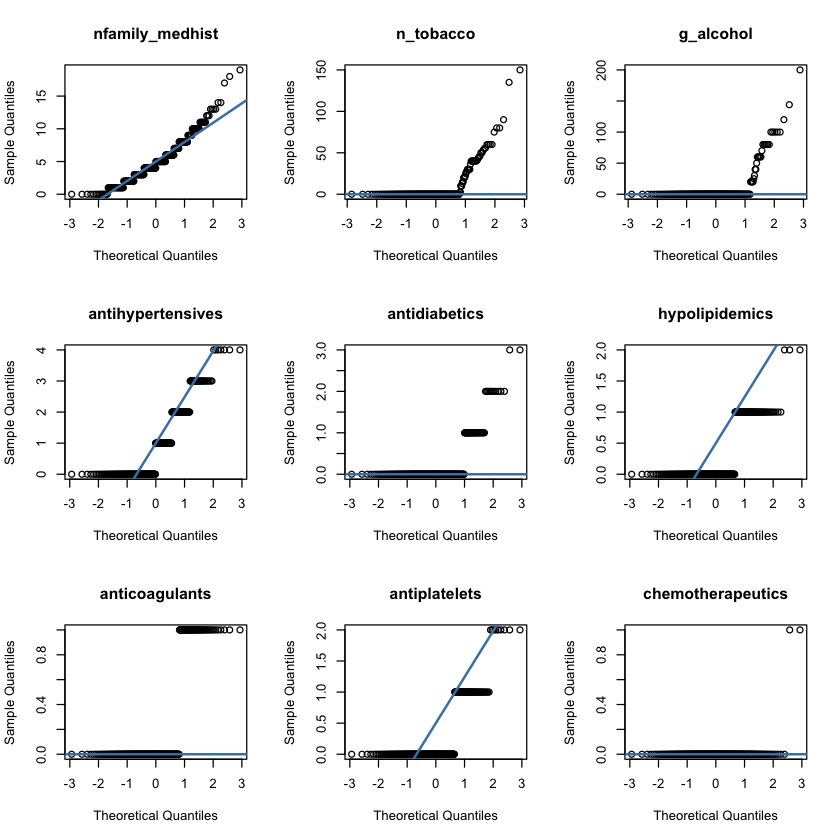

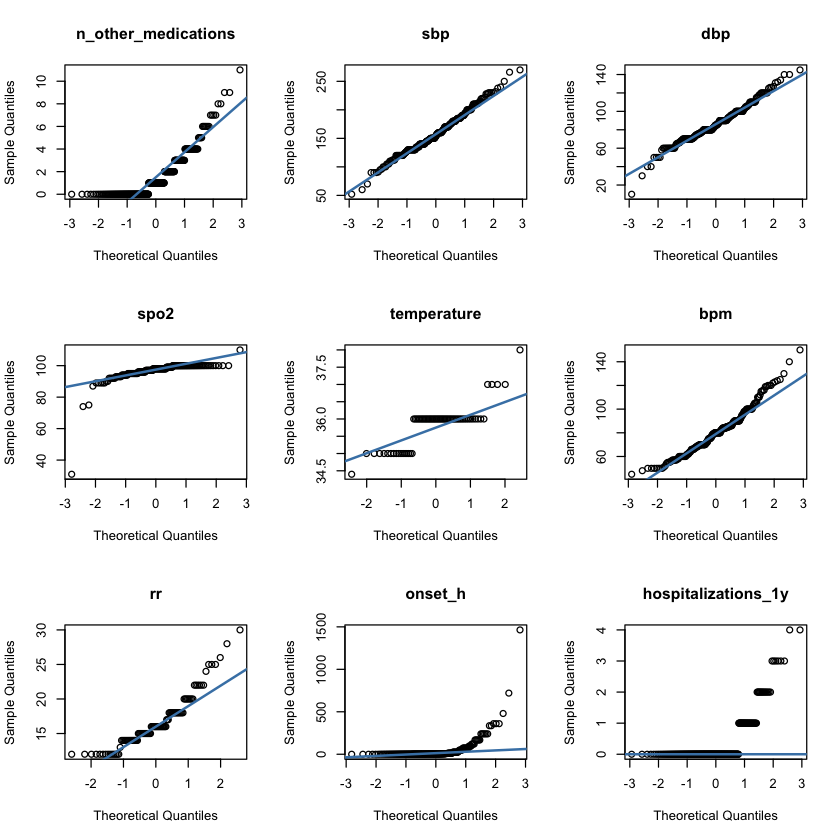

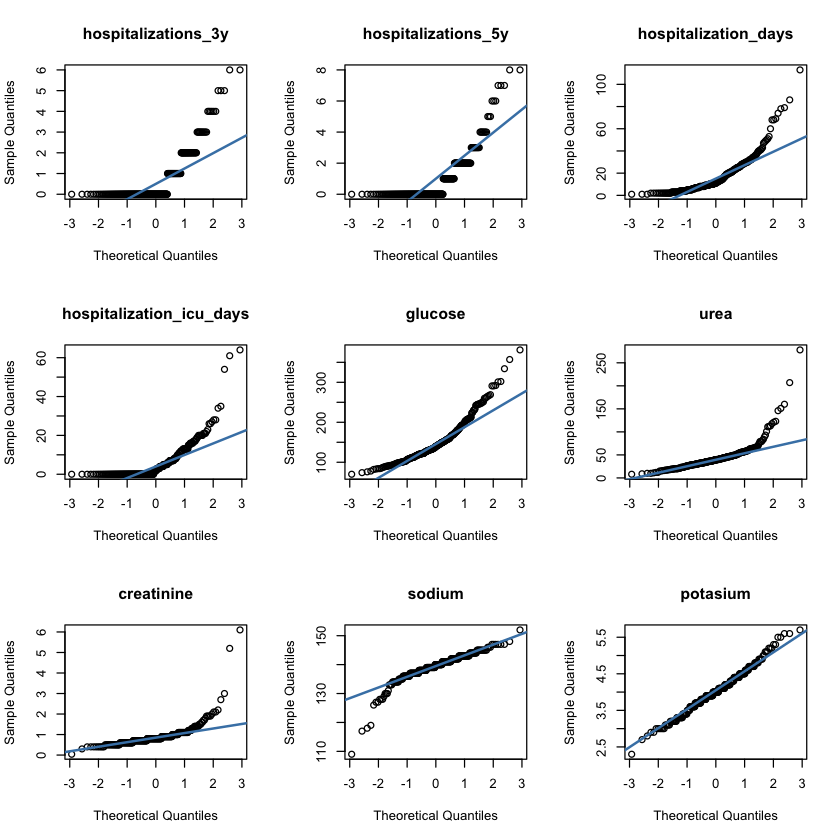

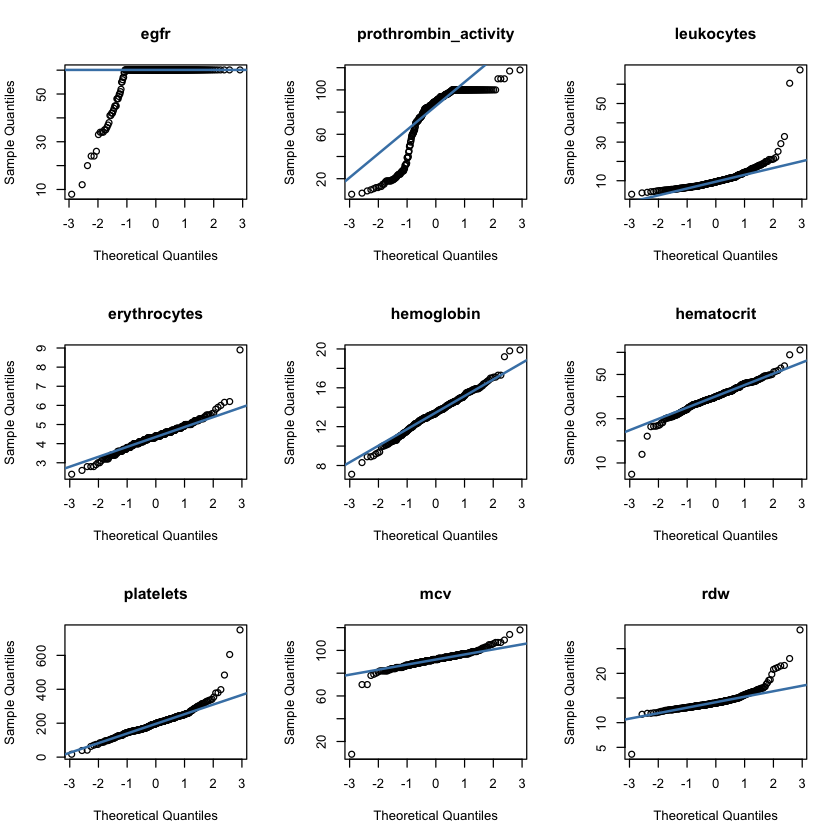

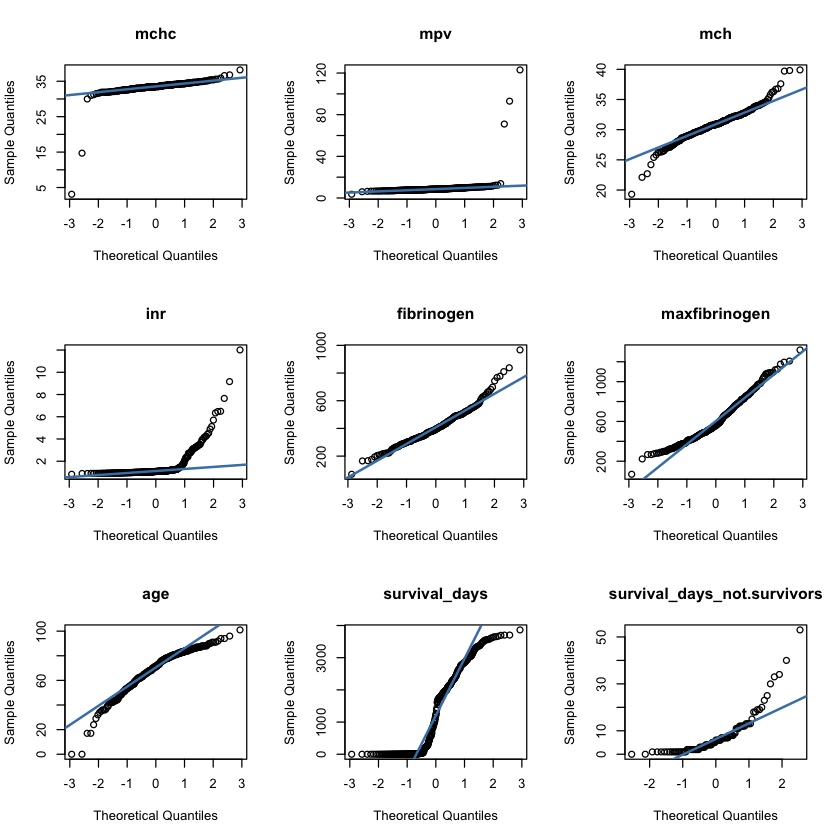

In [8]:
counter= 0
for (quantitative in names(quantitatives)) {
    if (counter %in% c(9*c(0:5))){par(mfrow=c(3,3))}
    stats::qqnorm(df[[quantitative]], pch=1, frame=TRUE, main=quantitative)
    stats::qqline(df[[quantitative]], col='steelblue', lwd=2)
    counter= counter+1
}

### 2.4. Summary: normally distributed variables

In [9]:
norm_vars= c('sbp', 'hemoglobin', 'potasium')

### 3 - Correlation analysis
- **Correlation analysis:** *Person's coefficient* and *Spearman's rank coefficient.*
- **Correlation heatmaps:** *Person's coefficient* and *Spearman's rank coefficient.*
- **Summary:** correlated variables (normally distributed variables based on Person's coefficient and non-normally distributed variables on Spearman's rank coefficient).

*Notes*:
   - *The cutoff point chosen for indicate correlation was* ***0.5***.
   - ***P-values*** *are adjusted following False Discovery Rate (****FDR****) method* - explain in point *4 - Statistical tests: hypothesis contrasts*.

### 3.1. Correlation analysis

**Correlation analysis** is a statistical technique used to describe the **size** and **direction** of a relationship between two or more variables. Although there are coeficients to calculate correlation between qualitative data (such as tetrachoric coefficient), oftenly in medicine correlations are only estimated in quantitative and sometimes ordinal data. Therefore, in this project the correlation analysis is computed with the quantitative variables, including also a qualitative ordinal variable, the total Glasgow Coma Scale. The correlation coefficients chosen are ***Pearson's coefficient (r)*** for normally distributed data, and ***Spearman's rank coefficient (rho)*** for non-normally distributed data.

Usually in biostatistics, the interpretation of **correlation coefiencients** are (absolute value): **<0.1** - no relevant correlation; **0.1-0.3** - very weak correlation; **0.3-0.5** - moderate correlation; **0.5-0.7** - strong correlation; **0.7-0.9** - very strong correlation; **>0.9** - almost perfect correlation. Of course, the negative sign indicates a negative correlation and the positive sign indicates a positive correlation.

Considering these values, the following correlation cutoff was defined.

In [10]:
corr_cutoff= 0.5

Before starting the correlation analysis, the variable type of *tgcs* (total Glasgow Coma Scale), which can be classified as an ordinal qualitative variable or as a Likert variable, was changed from factor to numeric to allow the correlation analysis.

In [11]:
quantitatives['tgcs']= as.numeric(df[['tgcs']])

#### 3.1.1. Person's coefficient (r)

In [12]:
pears= psych::corr.test(quantitatives[-c(2,45)], # exclusion of n_tobacco and survival_days_not.survivors (too much NAs)
                        use='complete.obs', method='pearson', adjust='fdr')

high_pears_idx=   which(abs(pears$r) > corr_cutoff & row(pears$r) < col(pears$r), arr.ind=TRUE)
high_pears_idx_2= which(abs(pears$ci$r) > corr_cutoff, arr.ind=TRUE)

high_pears= cbind(
                  var1=colnames(pears$r)[high_pears_idx[1:(length(high_pears_idx)/2)]],
                  var2=colnames(pears$r)[high_pears_idx[((length(high_pears_idx)/2)+1):length(high_pears_idx)]],
                  corrPears_r=round(pears$r[high_pears_idx],4),
                  ci.lower_fdr=NA,
                  ci.upper_fdr=NA,
                  p.value_fdr=round(pears$p[high_pears_idx],4)) #p values above the diagonal are the same as p.adjust values

high_pears[,6]= ifelse(high_pears[,6] == '0', '<0.0001', high_pears[,6])
high_pears= high_pears[order(as.numeric(as.character(high_pears[,3])), decreasing=TRUE),]

high_pears2= cbind(
                   corrPears_r2=round(pears$ci$r[high_pears_idx_2],4),
                   ci.lower_fdr=round(pears$ci.adj$lower[high_pears_idx_2],4),
                   ci.upper_fdr=round(pears$ci.adj$upper[high_pears_idx_2],4))

high_pears2= high_pears2[order(as.numeric(as.character(high_pears2[,3])), decreasing=TRUE),]

high_pears[,4]= high_pears2[,2]
high_pears[,5]= high_pears2[,3]

high_pears

var1,var2,corrPears_r,ci.lower_fdr,ci.upper_fdr,p.value_fdr
hemoglobin,hematocrit,0.9846,0.9754,0.9903,<0.0001
mcv,mch,0.9763,0.9621,0.9852,<0.0001
anticoagulants,inr,0.9569,0.9309,0.9732,<0.0001
hospitalizations_5y,survival_days,0.93,0.8905,0.9557,<0.0001
urea,leukocytes,0.8807,0.8155,0.9239,<0.0001
erythrocytes,hematocrit,0.8429,0.7597,0.8989,<0.0001
erythrocytes,hemoglobin,0.779,0.6681,0.856,<0.0001
hospitalizations_3y,hospitalizations_5y,0.7412,0.6161,0.8299,<0.0001
urea,creatinine,0.7254,0.5938,0.8192,<0.0001
hypolipidemics,antiplatelets,0.7125,0.5688,0.8115,<0.0001


#### 3.1.2. Spearman's rank coefficient (rho)

In [13]:
spear= psych::corr.test(quantitatives[-c(2,45)], # exclusion of n_tobacco and survival_days_not.survivors (too much NAs)
                        use='complete.obs', method='spearman', adjust='fdr')

high_spear_idx=   which(abs(spear$r) > corr_cutoff & row(spear$r) < col(spear$r), arr.ind=TRUE)
high_spear_idx_2= which(abs(spear$ci$r) > corr_cutoff, arr.ind=TRUE)

high_spear= cbind(
                  var1=colnames(spear$r)[high_spear_idx[1:(length(high_spear_idx)/2)]],
                  var2=colnames(spear$r)[high_spear_idx[((length(high_spear_idx)/2)+1):length(high_spear_idx)]],
                  corrSpear_rho=round(spear$r[high_spear_idx],4),
                  ci.lower_fdr=NA,
                  ci.upper_fdr=NA,
                  p.value_fdr=round(spear$p[high_spear_idx],4)) #p values above the diagonal are the same as p.adjust values

high_spear[,6]= ifelse(high_spear[,6] == '0', '<0.0001', high_spear[,6])
high_spear= high_spear[order(as.numeric(as.character(high_spear[,3])), decreasing=TRUE),]

high_spear2= cbind(
                   corrSpear_rho2=round(spear$ci$r[high_spear_idx_2],4),
                   ci.lower_fdr=round(spear$ci.adj$lower[high_spear_idx_2],4),
                   ci.upper_fdr=round(spear$ci.adj$upper[high_spear_idx_2],4))

high_spear2= high_spear2[order(as.numeric(as.character(high_spear2[,3])), decreasing=TRUE),]

high_spear[,4]= high_spear2[,2]
high_spear[,5]= high_spear2[,3]

high_spear

var1,var2,corrSpear_rho,ci.lower_fdr,ci.upper_fdr,p.value_fdr
hemoglobin,hematocrit,0.9911,0.9858,0.9945,<0.0001
mcv,mch,0.9578,0.933,0.9735,<0.0001
hospitalizations_5y,survival_days,0.872,0.8029,0.918,<0.0001
hospitalizations_3y,hospitalizations_5y,0.8194,0.726,0.883,<0.0001
erythrocytes,hematocrit,0.7374,0.6103,0.8275,<0.0001
sbp,dbp,0.7281,0.5927,0.8235,<0.0001
hypolipidemics,antiplatelets,0.7125,0.556,0.8167,<0.0001
fibrinogen,survival_days,0.7099,0.5516,0.8146,<0.0001
prothrombin_activity,fibrinogen,0.7067,0.5768,0.8099,<0.0001
erythrocytes,hemoglobin,0.6921,0.5487,0.7959,<0.0001


#### 3.2 Correlation heatmaps

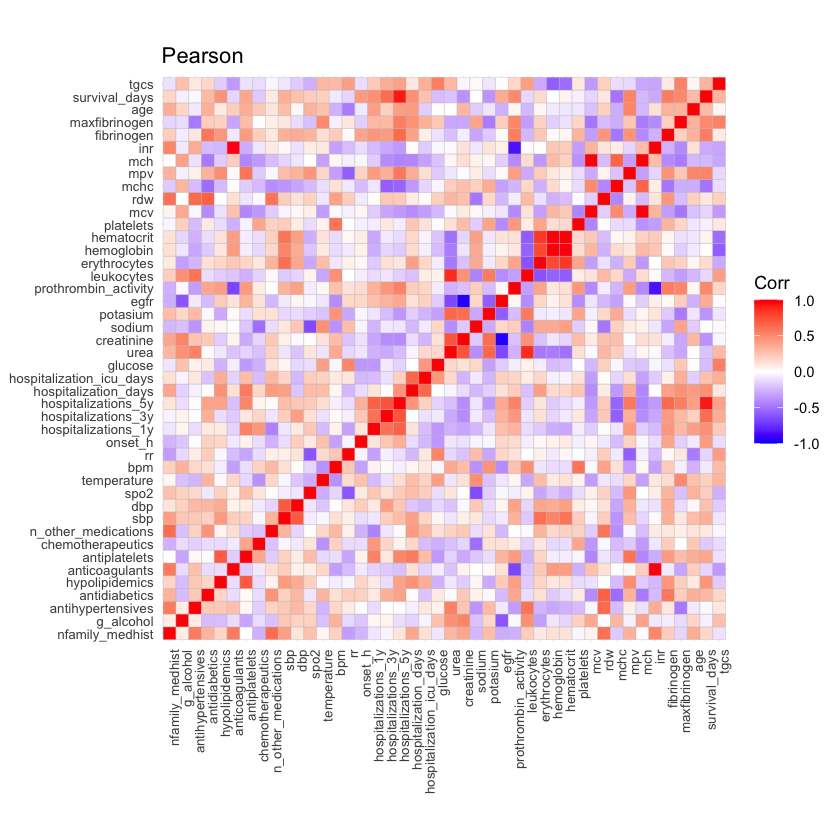

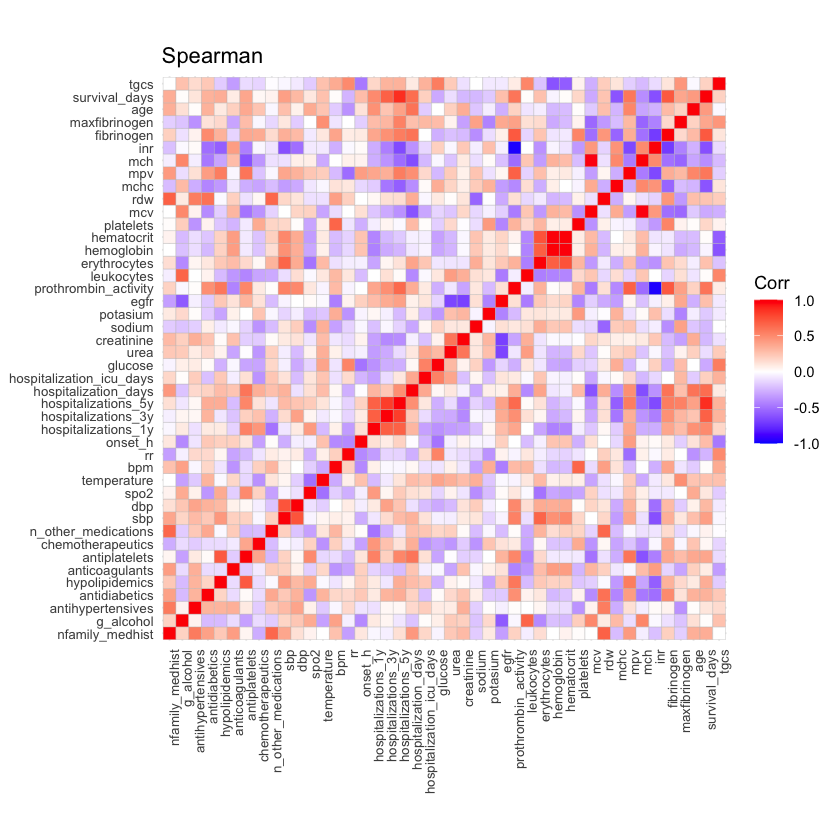

In [14]:
ggcorrplot::ggcorrplot(cor(quantitatives[-c(2,45)], use='complete.obs', method=c('pearson')), title='Pearson', tl.cex=8, tl.srt=90)
ggcorrplot::ggcorrplot(cor(quantitatives[-c(2,45)], use='complete.obs', method=c('spearman')), title='Spearman', tl.cex=8, tl.srt=90)

#### 3.2 Summary: correlated variables (correlation cutoff point r/rho > 0.5)

In [15]:
corr_vars= rbind(
                 high_pears[ (high_pears[,1] %in% norm_vars & high_pears[,2] %in% norm_vars),], # Norm_vars (Pearson)
                 high_spear[!(high_spear[,1] %in% norm_vars & high_spear[,2] %in% norm_vars),]) # Non-Norm_vars (Spearman)

colnames(corr_vars)[3]= 'r/rho'
corr_vars

var1,var2,r/rho,ci.lower_fdr,ci.upper_fdr,p.value_fdr
sbp,hemoglobin,0.5335,0.3597,0.6888,<0.0001
hemoglobin,hematocrit,0.9911,0.9858,0.9945,<0.0001
mcv,mch,0.9578,0.933,0.9735,<0.0001
hospitalizations_5y,survival_days,0.872,0.8029,0.918,<0.0001
hospitalizations_3y,hospitalizations_5y,0.8194,0.726,0.883,<0.0001
erythrocytes,hematocrit,0.7374,0.6103,0.8275,<0.0001
sbp,dbp,0.7281,0.5927,0.8235,<0.0001
hypolipidemics,antiplatelets,0.7125,0.556,0.8167,<0.0001
fibrinogen,survival_days,0.7099,0.5516,0.8146,<0.0001
prothrombin_activity,fibrinogen,0.7067,0.5768,0.8099,<0.0001


### 4 - Statistical tests: hypothesis contrasts

   - **Quantitative outcomes**
       - Vs quantitative predictors:
           - **Pearson's correlation coeficient**: two independent parametric variables.
           - **Spearman's rank correlation coeficient**: two independent non parametric variables.
       - Vs qualitative predictors:
          - **Student's t test**: two independent parametric samples of a quantitative variable.
          - **ANOVA**: more than two independent parametric samples of a quantitative variable.
          - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
          - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
          - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.


   - **Qualitative outcomes**
       - Vs quantitative predictors:
         - **Student's t test**: two independent parametric samples of a quantitative variable.
         - **ANOVA**: more than two independent parametric samples of a quantitative variable.
         - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
         - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
         - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.

       - Vs qualitative predictors:
         - Contingency tables $RxC$ when at least the 80% of the expected frequencies (($row$ $total$ $*$ $column$ $total)/N$) are equal to or greater than 5:
           - **Chi-square test**: contingency tables with > 80% expected frequencies n ≥ 5, regardless of row and column sizes.
           - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.

         - Contingency tables $RxC$ when at least the 20% of the expected frequencies are lesser than 5:
           - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.
           - **Fisher's exact test**: contingency tables 2x2 with > 20% expected frequencies n < 5.
           - **Fisher-Freeman-Halton**: Contingency tables > 2x2 with > 20% expected frequencies n < 5.
       
           *Note: For Monte Carlo simulation, 1.000.000 replicates was used.*

###### NOTES

###### Hypothesis Contrast

In inferencial statistics, a **hypothesis contrast** is a test to evaluate whether an observation is compatible with the properties assumed for a population. The fisrt step is to state the **null hypothesis (H0)** and the **alternative hypothesis (HA)**. Null hypothesis usually establishes that there are not differences between the sample observed and the population. Alternative hypothesis can specify that the observation are different (two tailed) or greater or lesser (one tailed) than what is expected for the population.

The second step is to decide a ***significance level* ($\alpha$)**. Later, the third step is to compute the propability of obtaining a sample at least as extreme as the observed sample, assuming that it comes from the population, or what means the same, assuming that the H0 is correct. This propabability is called ***p-value***. Finally, the *p-value* is compared with $\alpha$: if *p-value* $<$ $\alpha$, H0 is rejected and HA is supported, and if *p-value* $≥$ $\alpha$, H0 is not rejected.

The final aim of this technique is to discover if there are **statistically significant differences** among two or more samples or observations, establishing **associations between two or more variables**. However, this is not the only technique to check for the statistical significance or to search for associations among variables. Another possible option is to calculate **confidence intervals** for quotients (risks, ratios, correlations, etc.) or for differences of measures between two or more samples, establishing the statistical significance when the confidence interval excludes the null value (1 for quotients and 0 for differences). The confidence level of the confidence interval required to prove statistical significance, depends on the $\alpha$ value decided: for example if an $\alpha$ of 0.05 is decided, a statistically significant difference can be proven if the 95% confidence interval excludes de null value. However, for an $\alpha$ of 0.01, a 99% confidence interval excluding the null value is needed to prove statistical significance.

There are several **statistical tests** to calculate a *p-value*, and the selection of the appropriate test for each case depends on the **shape** and **spread** of the **distribution** of each variable and group to compare. A brief summary for independent samples is just above in point *4 - Statistical tests: hypothesis contrasts*. Another very relavant issue when working with large databases and *p-values*, is to control the Type I error, also called $\alpha$ error. This error is committed when supporting the alternate hypothesis being the null hypothesis true. As in medicine an $\alpha$ value of 0.05 is usually establish as the critical point for statistical significance, when many hypothesis contrasts are carry out at the same time (***multiple testing***), approximately the 5% of the discovered associations will be false. Therefore, a **correction of the *p-values*** is necessary to ensure that results are credible. One approach to do that are ***False Discovery Rate (FDR)*** techniques.

###### False Discovery Rate (*FDR*)

"***False discovery rate*** (FDR) is a method of conceptualizing the rate of type I errors in null hypothesis testing when conducting multiple comparisons. FDR-controlling procedures are designed to control the FDR, which is the expected proportion of discoveries (rejected null hypotheses) that are false (incorrect rejections of the null). Simply put, FDR = FP / (FP + TP). FDR-controlling procedures provide less stringent control of Type I errors compared to *family-wise error rate* (FWER) controlling procedures (such as the ***Bonferroni correction***), which control the probability of at least one Type I error. Thus, FDR-controlling procedures have greater power, at the cost of increased numbers of Type I errors" [1].

This project corrects *p-values* using ***Benjamini & Hochberg FDR method*** [2], one of the most popular technique use nowadays. This method is less stringent than family-wise error rate techniques, being more powerful [3,4].


***References***
1. False discovery rate. [Wiki]. 2023. Available from: https://en.wikipedia.org/wiki/False_discovery_rate [Accessed 20 May 2023].

2. Benjamini Y., Hochberg Y. Controlling the false discovery rate: a practical and powerful approach to multiple testing. J R Stat Soc Ser B Methodol. 1995;57:289-300. Available in: http://www.jstor.org/stable/2346101.

3. Korthauer K, Kimes PK, Duvallet C, Reyes A, Subramanian A, Teng M, Shukla C, Alm EJ, Hicks SC. A practical guide to methods controlling false discoveries in computational biology. Genome Biol. 2019 Jun 4;20(1):118. doi: 10.1186/s13059-019-1716-1. PMID: 31164141; PMCID: PMC6547503. Available in: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1716-1

4. R Core Team (2019). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.
 - stats::p.adjust: https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/p.adjust

### 4.1. Quantitative outcomes

   - Vs quantitative predictors:
       - **Pearson's correlation coeficient**: two independent parametric variables.
       - **Spearman's rank correlation coeficient**: two independent non parametric variables.
   - Vs qualitative predictors:
      - **Student's t test**: two independent parametric samples of a quantitative variable.
      - **ANOVA**: more than two independent parametric samples of a quantitative variable.
      - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
      - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
      - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.

In [16]:
quant_outcomes= as.character(df_metadata[(df_metadata$Type_of_Variable %like% 'Outcome' & df_metadata$R_Datatype == 'numeric'),'Variable_Label'])
quant_outcomes= append(quant_outcomes, 'survival_days_not.survivors')
quant_outcomes

[1] "hospitalizations_1y"         "hospitalizations_3y"        
[3] "hospitalizations_5y"         "hospitalization_days"       
[5] "survival_days"               "survival_days_not.survivors"

#### 4.1.1. Quantitative outcomes vs quantitative predictors

   - **Pearson's correlation coeficient**: two independent parametric variables
   - **Spearman's rank correlation coeficient**: two independent non parametric variables
   
*Note: correlation analysis was done in point 3 - Correlation analysis*.

###### NOTE

In statistics, the main techniques to establish relationship between **quantitative data** are **correlation** analysis (studies if relationship exists, and its direction and magnitude) and **regression** (used to predict the value of a depedent variable based on the values of other independent variables).

Although it is possible to study correlations between three or more variables, in medicine, correlation is usually studied among two variables. Therefore, in this point binary correlations between quantitave variables are studied. Regression analysis are conducted in Notebooks *5.2 Inferential Statistics - Survival Analysis (R)* and *7. Kernel Regressions*.

Note that correlation coefficients have to be always accompanied by a **p-value** or better, by a ***confidence interval***. The *p-value* indicates if the correlation is statistically significant and  it is the result of doing the following hypothesis contrast: H0: r = 0 and HA: r != 0. However, *confidence intervals* gives much more information. They inform about the significance of the correlation (if the confidence interval excludes the value 0 the correlation is statistically significant), but also gives information about the precision of the coefficient value.

In [17]:
quant_outcomes

[1] "hospitalizations_1y"         "hospitalizations_3y"        
[3] "hospitalizations_5y"         "hospitalization_days"       
[5] "survival_days"               "survival_days_not.survivors"

In [18]:
quant_predictors= as.character(df_metadata[(df_metadata$Type_of_Variable %like% 'Predictor' & df_metadata$R_Datatype == 'numeric'),'Variable_Label'])
quant_predictors

[1] "nfamily_medhist"          "n_tobacco"               
 [3] "g_alcohol"                "antihypertensives"       
 [5] "antidiabetics"            "hypolipidemics"          
 [7] "anticoagulants"           "antiplatelets"           
 [9] "chemotherapeutics"        "n_other_medications"     
[11] "sbp"                      "dbp"                     
[13] "spo2"                     "temperature"             
[15] "bpm"                      "rr"                      
[17] "onset_h"                  "hospitalizations_1y"     
[19] "hospitalizations_3y"      "hospitalizations_5y"     
[21] "hospitalization_days"     "hospitalization_icu_days"
[23] "glucose"                  "urea"                    
[25] "creatinine"               "sodium"                  
[27] "potasium"                 "egfr"                    
[29] "prothrombin_activity"     "leukocytes"              
[31] "erythrocytes"             "hemoglobin"              
[33] "hematocrit"               "platelets"               
[35] "mcv"                      "rdw"                     
[37] "mchc"                     "mpv"                     
[39] "mch"                      "inr"                     
[41] "fibrinogen"               "maxfibrinogen"           
[43] "age"

###### NOTE

The correlation coefficients (***Pearson's*** and ***Spearman's***) are calculated in point *3 - Correlation analysis*. Here, correlations above the cutoff defined in point 3 in which there are any quantitative outcome are printed.

In [19]:
corr_vars[corr_vars[,1] %in% quant_outcomes | corr_vars[,2] %in% quant_outcomes,]

var1,var2,r/rho,ci.lower_fdr,ci.upper_fdr,p.value_fdr
hospitalizations_5y,survival_days,0.872,0.8029,0.918,<0.0001
hospitalizations_3y,hospitalizations_5y,0.8194,0.726,0.883,<0.0001
fibrinogen,survival_days,0.7099,0.5516,0.8146,<0.0001
hospitalizations_1y,hospitalizations_3y,0.691,0.5479,0.7949,<0.0001
hospitalizations_1y,hospitalizations_5y,0.6795,0.5235,0.7883,<0.0001
hospitalizations_3y,survival_days,0.6774,0.5325,0.7867,<0.0001
hospitalizations_5y,prothrombin_activity,0.6365,0.4738,0.7572,<0.0001
hospitalization_days,survival_days,0.6347,0.193,0.7566,<0.0001
hospitalization_days,fibrinogen,0.5984,0.4059,0.74,<0.0001
hospitalization_days,age,0.5969,0.4377,0.7386,<0.0001


One of the best plots to visualize correlations and regressions, are ***scatter plots***.

`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'

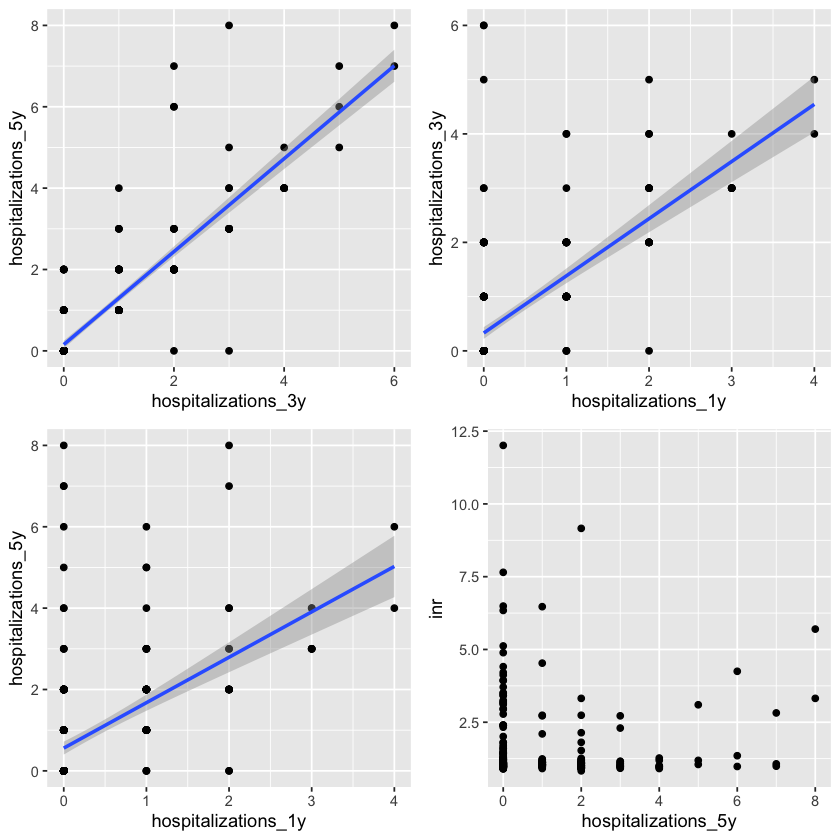

In [20]:
defaultW= getOption('warn'); options(warn=-1)
options(repr.plot.width=7, repr.plot.height=7)

cowplot::plot_grid(ggplot(df, aes(x=hospitalizations_3y, y=hospitalizations_5y)) + geom_point() + geom_smooth(method=lm),
                   ggplot(df, aes(x=hospitalizations_1y, y=hospitalizations_3y)) + geom_point() + geom_smooth(method=lm),
                   ggplot(df, aes(x=hospitalizations_1y, y=hospitalizations_5y)) + geom_point() + geom_smooth(method=lm),
                   ggplot(df, aes(x=hospitalizations_5y, y=inr))                 + geom_point())

options(warn=defaultW)

#### 4.1.2. Quantitative outcomes vs qualitative predictors

   - **Student's t test**: two independent parametric samples of a quantitative variable.
   - **ANOVA**: more than two independent parametric samples of a quantitative variable.
   - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
   - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
   - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.

In [21]:
quant_outcomes

[1] "hospitalizations_1y"         "hospitalizations_3y"        
[3] "hospitalizations_5y"         "hospitalization_days"       
[5] "survival_days"               "survival_days_not.survivors"

In [22]:
qual_predictors= as.character(df_metadata[(df_metadata$Type_of_Variable %like% 'Predictor' & df_metadata$R_Datatype == 'factor'),'Variable_Label'])
qual_predictors

[1] "sex"                           "tobacco"                      
 [3] "drugs"                         "alcohol"                      
 [5] "ht"                            "dmellitus"                    
 [7] "dyslipidemia"                  "previous_ich"                 
 [9] "cv_diseases"                   "carrhythmias"                 
[11] "structural_heart_disease"      "vascular_diseases"            
[13] "neurological_diseases"         "dementia"                     
[15] "depression"                    "psychiatric_diseases"         
[17] "cancerous_autoimmune_diseases" "cancerous_diseases"           
[19] "autoimmune_diseases"           "hyper_hypo_thyroidism"        
[21] "haematological_disorders"      "other_diseases"               
[23] "digoxin"                       "aceis"                        
[25] "arbs"                          "ccbs"                         
[27] "bblockers"                     "ablockers"                    
[29] "ablockers1"                    "ablockers2"                   
[31] "diuretics"                     "other_antihypertensives"      
[33] "biguanides"                    "sulfonylureas"                
[35] "glinides"                      "glp1a"                        
[37] "dpp4i"                         "agi"                          
[39] "insulin"                       "statins"                      
[41] "aspirin"                       "p2y12b"                       
[43] "gIIbIIIai"                     "cumarinics"                   
[45] "noac"                          "dabigatran"                   
[47] "rivaroxaban"                   "other_medications"            
[49] "headache"                      "emesis"                       
[51] "visual_disturbances"           "seizures"                     
[53] "mh_trauma"                     "mh_le_trauma"                 
[55] "mh_he_trauma"                  "other_symptoms"               
[57] "neurol_signs"                  "diplopia"                     
[59] "anisocoria"                    "aphasia"                      
[61] "dysarthria"                    "altered_consciousness"        
[63] "nuchal_rigidity"               "rfacial_palsy"                
[65] "lfacial_palsy"                 "ruplimb_mimpairment"          
[67] "luplimb_mimpairment"           "rlwlimb_mimpairment"          
[69] "llwlimb_mimpairment"           "balance_impairment"           
[71] "tgcs"                          "primary_ich"                  
[73] "vascular_ich"                  "traumatic_ich"                
[75] "ht_ich"                        "amyloidangiopathy_ich"        
[77] "aneurysmal_ich"                "avm_ich"                      
[79] "hti_ich"                       "other_ich"

###### NOTE

**Normality**, **shape** and **spread** of each group to be compare should be checked for all variables in order to choose the most aproppriate statistical test (*see the test above in this point 4.1.2*). One of the best manners to do it is by using ***violin*** and ***box plots***. However, taking into account the results found in the descriptive analysis performed in Notebooks 4.1 and 4.2, and earlier in this Notebook, it is very likely that almost all variables violate the assumptions of normality, equality of shapes and homoscedasticity. Therefore, **Mood's median test** was chosen, since this test is the most conservative and a significant result in it will be significant in the rest of the tests as well.

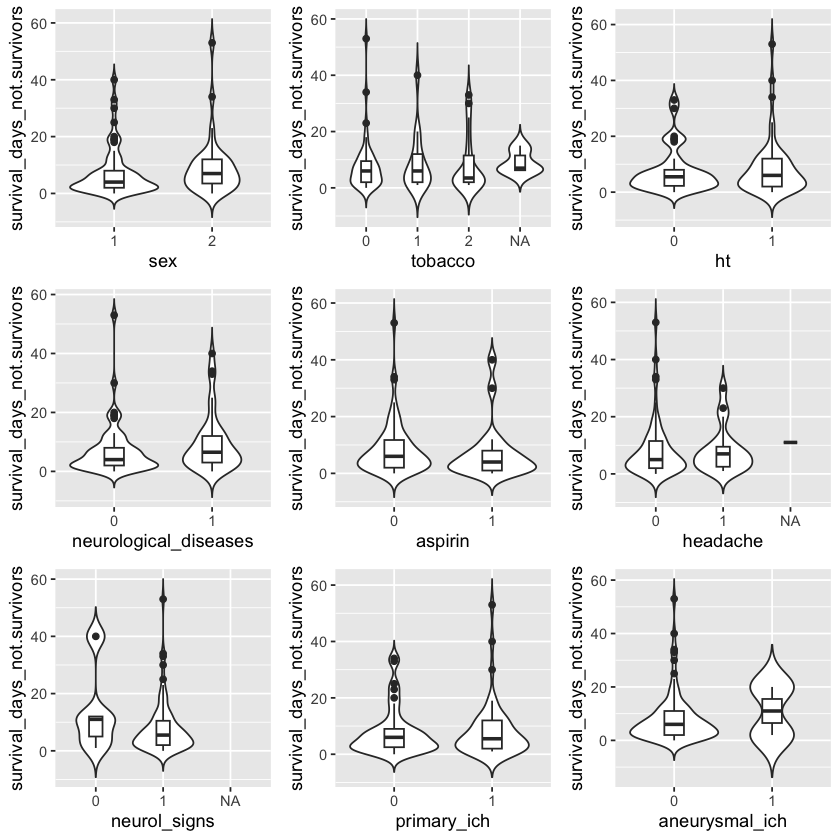

In [23]:
options(repr.plot.width=7, repr.plot.height=7)

cowplot::plot_grid(ggplot(df, aes(x=sex,                   y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=tobacco,               y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=ht,                    y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=neurological_diseases, y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=aspirin,               y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=headache,              y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=neurol_signs,          y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=primary_ich,           y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=aneurysmal_ich,        y=survival_days_not.survivors)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2))

In [24]:
# Mood's median test function
Median_test= function (df,x,y){
    
    Median.test_result= coin::pvalue(coin::median_test(df[[x]]~df[[y]],
                                                       alternative='two.sided', paired=FALSE, conf.level=0.95))
    return (c(x,y,Median.test_result))}


# Do the Mood's median tests excluding outcome 6 (survival_days_not.survivors) because it has NAs)
p.values_med.test1a= matrix(unlist(map2(.x= sort(rep(quant_outcomes[-6],length(qual_predictors))),
                                       .y= rep(qual_predictors, length(quant_outcomes[-6])),
                                       .f= function(x,y) Median_test(df=df,x,y))),
                                       ncol=3, byrow=TRUE)
                                  
                                  
# Do the Mood's median test for survival_days_not.survivors exluding predictors with too much Nas
df2= data.frame(df[!is.na(df$survival_days_not.survivors),]) # remove survival_days_not.survivors NAs
                                   
idx_nas= c(32,35,36,38,47)
p.values_med.test1b= matrix(unlist(map2(.x= sort(rep(quant_outcomes[6],length(qual_predictors[-idx_nas]))),
                                        .y= rep(qual_predictors[-idx_nas], length(quant_outcomes[6])),
                                        .f= function(x,y) Median_test(df=df2,x,y))),
                                        ncol=3, byrow=TRUE)
                                  
                                  
# Concatenate Mood's median tests
p.values_med.test1= rbind(p.values_med.test1a, p.values_med.test1b)
                                   

# Adjust p values with False Discovery Rate (FDR) method
p.values_med.test1= cbind(p.values_med.test1, p.adjust(p.values_med.test1[,3], method='fdr', n=nrow(p.values_med.test1)))

                               
# Rename and round columns
colnames(p.values_med.test1)= c('var1', 'var2', 'p._med.test', 'p.adj_fdr')
p.values_med.test1[,3:4]= round(as.numeric(p.values_med.test1[,3:4]),4)
p.values_med.test1[,3:4]= ifelse(p.values_med.test1[,3:4] == '0', '<0.0001', p.values_med.test1[,3:4])
                               

# Select significant Mood's median tests
alpha_med.test1= 0.05
sig_med.tests1= p.values_med.test1[which(p.values_med.test1[,4] < alpha_med.test1),]
sig_med.tests1  

var1,var2,p._med.test,p.adj_fdr
hospitalizations_5y,ruplimb_mimpairment,0.0013,0.047
hospitalizations_5y,rlwlimb_mimpairment,0.0011,0.047
survival_days,cv_diseases,<0.0001,0.0035
survival_days,carrhythmias,2e-04,0.015
survival_days,structural_heart_disease,<0.0001,0.0035
survival_days,neurological_diseases,3e-04,0.019
survival_days,cancerous_autoimmune_diseases,8e-04,0.0466
survival_days,diuretics,0.0014,0.047
survival_days,cumarinics,1e-04,0.015
survival_days,altered_consciousness,3e-04,0.019


###### NOTE

All significant tests come from binary outcomes, so there is not need to do ***post-hoc analysis***.

To graphically see the results, a good option is the use of ***box plots***.

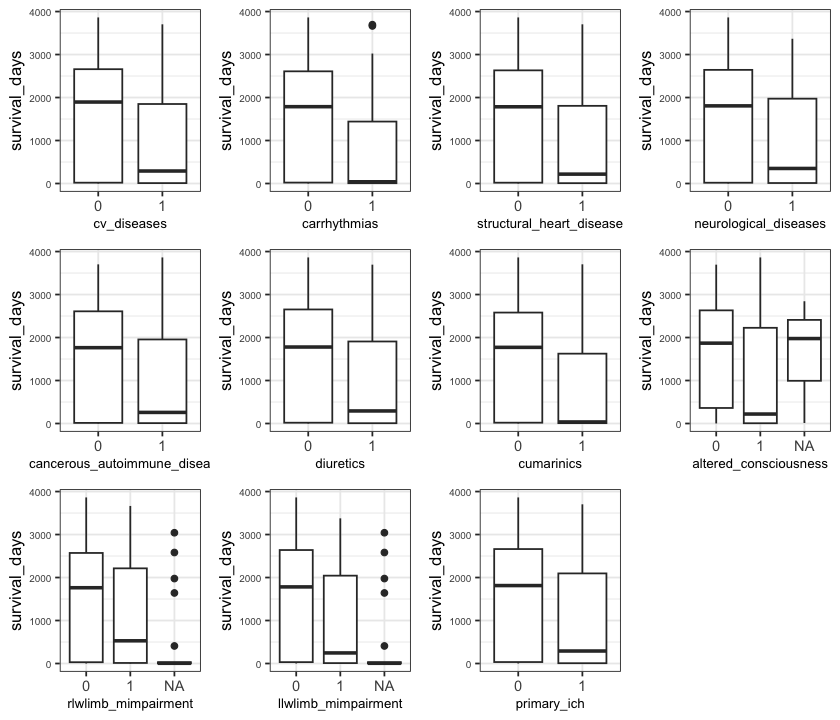

In [25]:
options(repr.plot.width=7, repr.plot.height=6)

cowplot::plot_grid(ggplot(df, aes(x=cv_diseases,                   y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=carrhythmias,                  y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=structural_heart_disease,      y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=neurological_diseases,         y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=cancerous_autoimmune_diseases, y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=diuretics,                     y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=cumarinics,                    y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=altered_consciousness,         y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=rlwlimb_mimpairment,           y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=llwlimb_mimpairment,           y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=primary_ich,                   y=survival_days))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)))

### 4.2. Qualitative outcomes

   - Vs quantitative predictors:
     - **Student's t test**: two independent parametric samples of a quantitative variable.
     - **ANOVA**: more than two independent parametric samples of a quantitative variable.
     - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
     - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
     - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.


   - Vs qualitative predictors:
     - Contingency tables $RxC$ when at least the 80% of the expected frequencies (($row$ $total$ $*$ $column$ $total)/N$) are equal to or greater than 5:
       - **Chi-square test**: contingency tables with > 80% expected frequencies n ≥ 5, regardless of row and column sizes.
       - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.

     - Contingency tables $RxC$ when at least the 20% of the expected frequencies are lesser than 5:
       - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.
       - **Fisher's exact test**: contingency tables 2x2 with > 20% expected frequencies n < 5.
       - **Fisher-Freeman-Halton**: Contingency tables > 2x2 with > 20% expected frequencies n < 5.
       
*Note: For Monte Carlo simulation, 1.000.000 replicates was used.*

In [26]:
qual_outcomes= as.character(df_metadata[(df_metadata$Type_of_Variable %like% 'Outcome' & df_metadata$R_Datatype == 'factor'),'Variable_Label'])
qual_outcomes

[1] "follow_up"          "final_outcome"      "survival_discharge"
 [4] "survival_3d"        "survival_6d"        "survival_9d"       
 [7] "survival_12d"       "survival_15d"       "survival_1m"       
[10] "survival_3m"        "survival_1y"        "survival_5y"       
[13] "survived"           "neurosurg"          "interprocedures"

#### 4.2.1 Qualitative outcomes vs quantitative predictors

   - **Student's t test**: two independent parametric samples of a quantitative variable.
   - **ANOVA**: more than two independent parametric samples of a quantitative variable.
   - **Mann–Whitney–Wilcoxon's u test**: two independent non parametric samples of a quantitative variable with similar shape and spread.
   - **Kruskal-Wallis**: more than two independent non parametric samples of a quantitative variable with similar shape and spread.
   - **Mood's median test**: non parametric samples of a quantitative variable with different shape and/or spread.

In [27]:
qual_outcomes

[1] "follow_up"          "final_outcome"      "survival_discharge"
 [4] "survival_3d"        "survival_6d"        "survival_9d"       
 [7] "survival_12d"       "survival_15d"       "survival_1m"       
[10] "survival_3m"        "survival_1y"        "survival_5y"       
[13] "survived"           "neurosurg"          "interprocedures"

In [28]:
quant_predictors

[1] "nfamily_medhist"          "n_tobacco"               
 [3] "g_alcohol"                "antihypertensives"       
 [5] "antidiabetics"            "hypolipidemics"          
 [7] "anticoagulants"           "antiplatelets"           
 [9] "chemotherapeutics"        "n_other_medications"     
[11] "sbp"                      "dbp"                     
[13] "spo2"                     "temperature"             
[15] "bpm"                      "rr"                      
[17] "onset_h"                  "hospitalizations_1y"     
[19] "hospitalizations_3y"      "hospitalizations_5y"     
[21] "hospitalization_days"     "hospitalization_icu_days"
[23] "glucose"                  "urea"                    
[25] "creatinine"               "sodium"                  
[27] "potasium"                 "egfr"                    
[29] "prothrombin_activity"     "leukocytes"              
[31] "erythrocytes"             "hemoglobin"              
[33] "hematocrit"               "platelets"               
[35] "mcv"                      "rdw"                     
[37] "mchc"                     "mpv"                     
[39] "mch"                      "inr"                     
[41] "fibrinogen"               "maxfibrinogen"           
[43] "age"

In [29]:
# Two or more samples?
bin_qual_outcomes=     unlist(map(.x=as.list(qual_outcomes), .f=function(x) if (length(table(df[x])) == 2){x}))
not.bin_qual_outcomes= unlist(map(.x=as.list(qual_outcomes), .f=function(x) if (length(table(df[x])) != 2){x}))

bin_qual_outcomes
not.bin_qual_outcomes

[1] "survival_discharge" "survival_3d"        "survival_6d"       
 [4] "survival_9d"        "survival_12d"       "survival_15d"      
 [7] "survival_1m"        "survival_3m"        "survival_1y"       
[10] "survival_5y"        "survived"           "interprocedures"

[1] "follow_up"     "final_outcome" "neurosurg"

###### NOTE

As in point 4.1.2, **normality**, **shape** and **spread** of each group to be compare should be checked for all variables in order to choose the most aproppriate statistical test. The *violin plots* help us to examine these three distribution features.

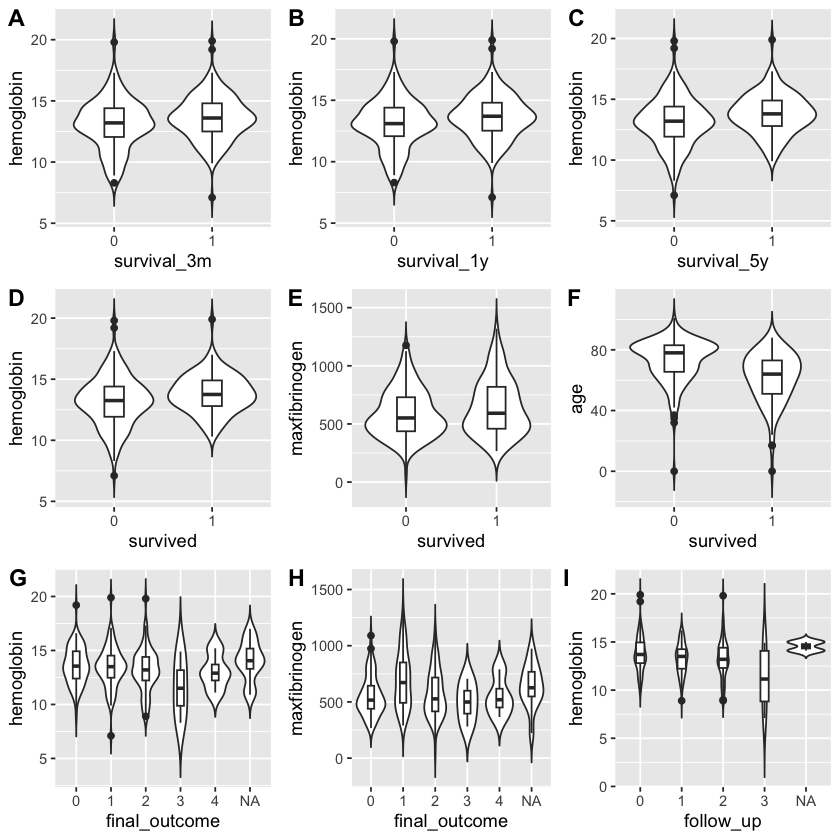

In [30]:
options(repr.plot.width=7, repr.plot.height=7)

cowplot::plot_grid(ggplot(df, aes(x=survival_3m,   y=hemoglobin))    + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=survival_1y,   y=hemoglobin))    + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=survival_5y,   y=hemoglobin))    + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=survived,      y=hemoglobin))    + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=survived,      y=maxfibrinogen)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=survived,      y=age))           + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=final_outcome, y=hemoglobin))    + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=final_outcome, y=maxfibrinogen)) + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                   ggplot(df, aes(x=follow_up,     y=hemoglobin))    + geom_violin(trim=FALSE) + geom_boxplot(width=0.2),
                labels=c('A','B','C','D','E','F','G','H','I'))

As it can be seen in the *violin plots*, the following groups were identified:
   - **Two** independent **samples**:
       - **Normally** distributed: **plots *A*, *B*, *C*, *D***.
       - **Non-normally** distributed:
           - Similar **shape** and **spread**: **plot *E***.
           - **Different** shape and spread: the **rest** of binary samples, as **plot *F***.
   - **Three or more** independent samples:
       - **Normally** distributed: there are not cases in this dataset.
       - **Non-normally** distributed:
           - Similar **shape** and **spread**: there are not cases in this dataset.
           - **Different** shape and spread: all non binary samples, as **plots *G*, *H*, *I***.

In [31]:
# All comparisons
bin_comp=     data.frame(matrix(c(sort(rep(bin_qual_outcomes,     length(quant_predictors))), rep(quant_predictors, length(bin_qual_outcomes))),    ncol=2))
not.bin_comp= data.frame(matrix(c(sort(rep(not.bin_qual_outcomes, length(quant_predictors))), rep(quant_predictors, length(not.bin_qual_outcomes))),ncol=2))

In [32]:
# Define all groups 

bin_normal_comp= data.frame(matrix(c('survival_3m','hemoglobin',
                                     'survival_1y','hemoglobin',
                                     'survival_5y','hemoglobin',
                                     'survived',   'hemoglobin'), ncol=2, byrow=TRUE))

bin_non.normal_same.shaped.spread_comp= data.frame(matrix(c('survived', 'maxfibrinogen'), ncol=2, byrow=TRUE))
bin_non.normal_diff.shaped.spread_comp= dplyr::anti_join(bin_comp,
                                                         rbind(bin_normal_comp, bin_non.normal_same.shaped.spread_comp),
                                                         by=names(bin_comp))


not.bin_normal_comp= data.frame(matrix(NA, ncol=2, byrow=TRUE)) # There are not cases in this dataset

not.bin_non.normal_same.shaped.spread_comp= data.frame(matrix(NA, ncol=2, byrow=TRUE)) # There are not cases in this dataset
not.bin_non.normal_diff.shaped.spread_comp= dplyr::anti_join(not.bin_comp,
                                                             rbind(not.bin_normal_comp, not.bin_non.normal_same.shaped.spread_comp),
                                                             by=names(not.bin_comp))

###### 4.2.1.1. Comparing two independent normally distributed samples - **Student's t tests**.

In [33]:
bin_normal_comp

X1,X2
survival_3m,hemoglobin
survival_1y,hemoglobin
survival_5y,hemoglobin
survived,hemoglobin


In [34]:
# Student's t test function
t_test= function (df,x,y){
    
    t.test_result= stats::t.test(x=df[which(df[x] == 0),y],
                                 y=df[which(df[x] == 1),y],
                                 alternative='two.sided', paired=FALSE, var.equal=TRUE, conf.level=0.95,
                                 na.action='na.omit')
    
    return (c(x,y,t.test_result$p.value))}


# Do the Student`s t tests


p.values_t.test= matrix(unlist(map2(.x= as.character(bin_normal_comp[[1]]),
                                    .y= as.character(bin_normal_comp[[2]]),
                                    .f= function(x,y) t_test(df=df,x,y))),
                                     ncol=3,
                                     byrow=TRUE)


# Adjust p values with False Discovery Rate (FDR) method
p.values_t.test= cbind(p.values_t.test, p.adjust(p.values_t.test[,3], method='fdr', n=nrow(p.values_t.test)))

                               
# Rename and round columns
colnames(p.values_t.test)= c('var1', 'var2', 'p._t.test', 'p.adj_fdr')
p.values_t.test[,3:4]= round(as.numeric(p.values_t.test[,3:4]),4)
p.values_t.test

var1,var2,p._t.test,p.adj_fdr
survival_3m,hemoglobin,0.0264,0.0264
survival_1y,hemoglobin,0.0146,0.0195
survival_5y,hemoglobin,0.0025,0.01
survived,hemoglobin,0.0055,0.0109


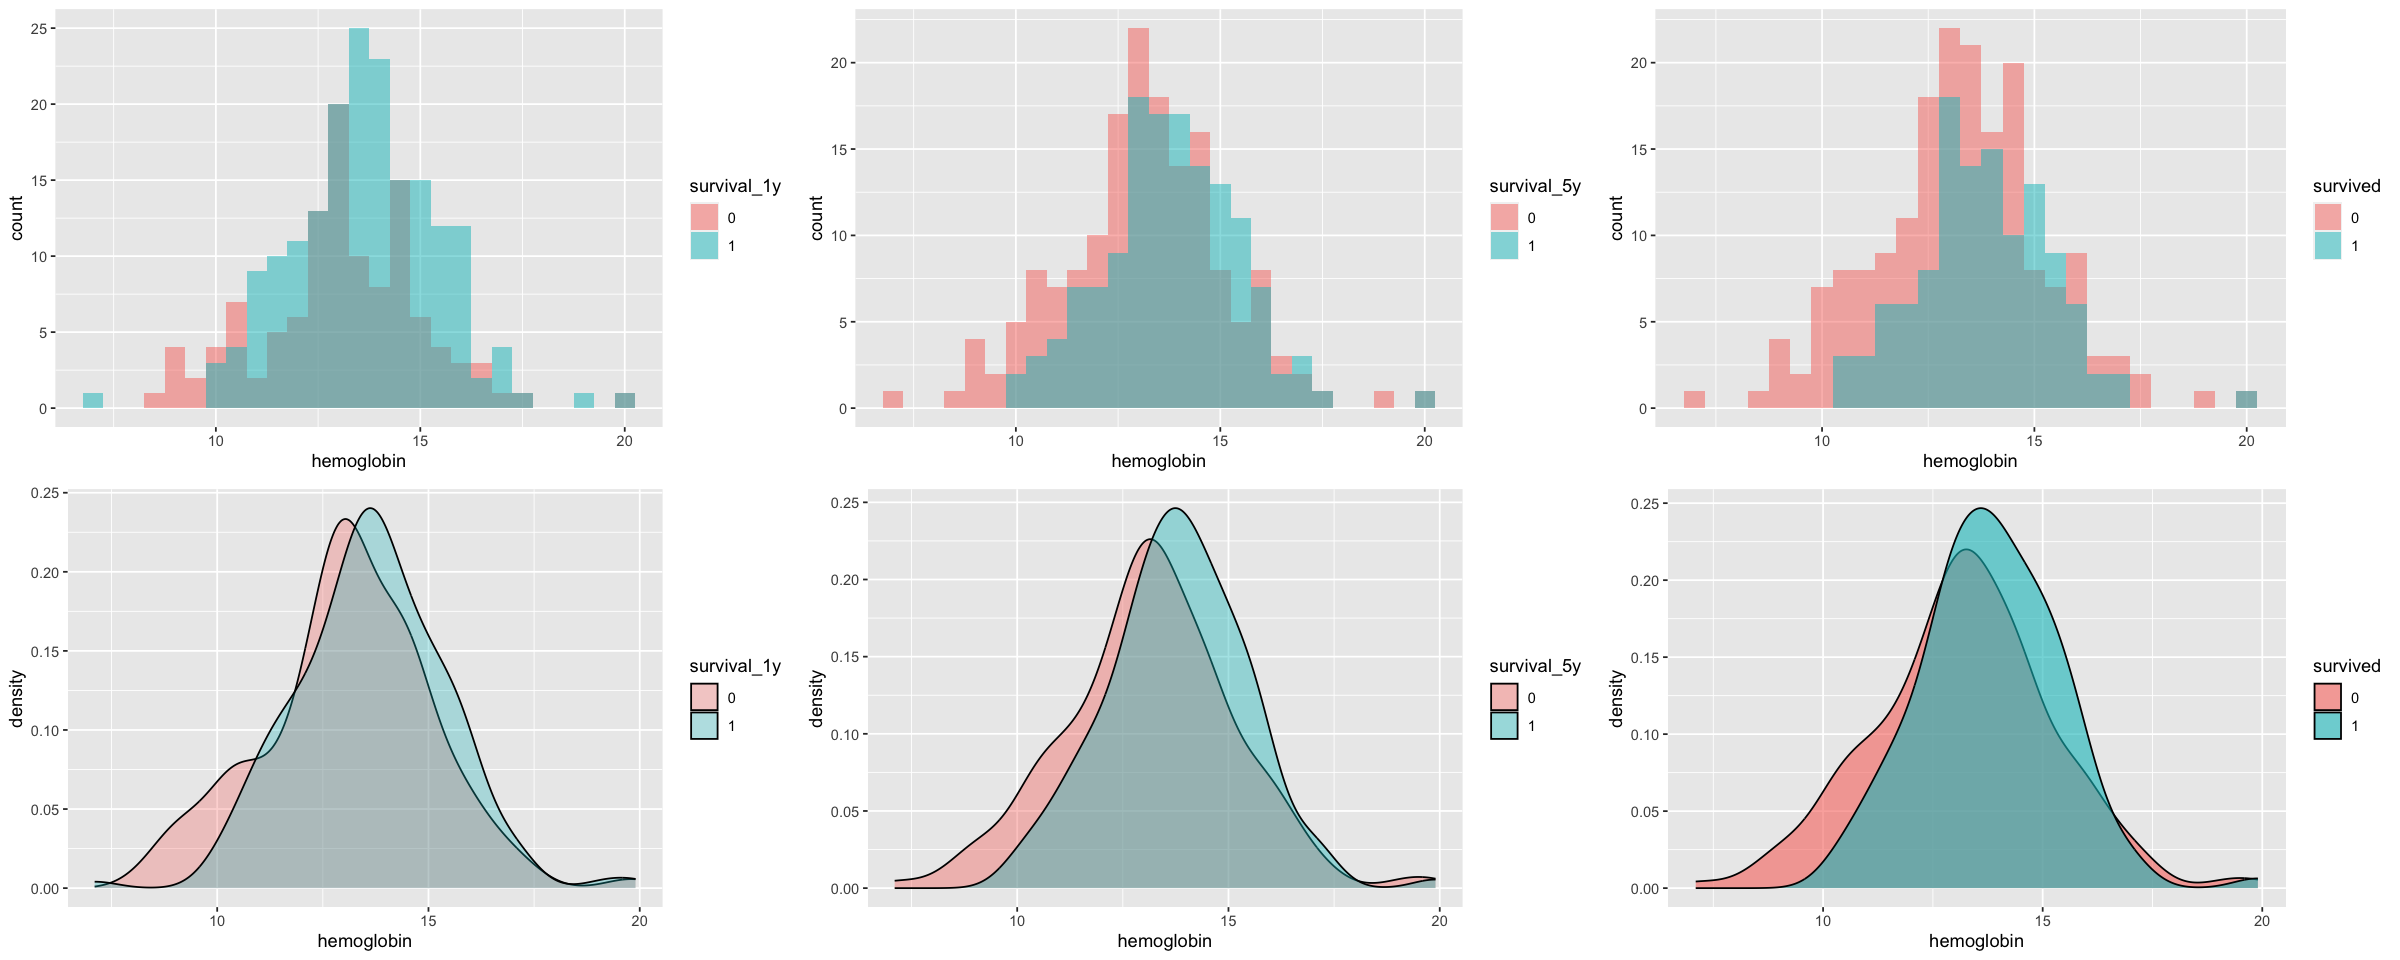

In [35]:
options(repr.plot.width=20, repr.plot.height=8)

cowplot::plot_grid(ggplot(df, aes(x=hemoglobin, fill=survival_1y)) + geom_histogram(binwidth=.5, alpha=.5, position='identity'),
                   ggplot(df, aes(x=hemoglobin, fill=survival_5y)) + geom_histogram(binwidth=.5, alpha=.5, position='identity'),
                   ggplot(df, aes(x=hemoglobin, fill=survived))    + geom_histogram(binwidth=.5, alpha=.5, position='identity'),
                   ggplot(df, aes(x=hemoglobin, fill=survival_1y)) + geom_density(alpha=.3),
                   ggplot(df, aes(x=hemoglobin, fill=survival_5y)) + geom_density(alpha=.4),
                   ggplot(df, aes(x=hemoglobin, fill=survived))    + geom_density(alpha=.6),
                  ncol=3)

###### 4.2.1.2. Comparing two independent non-normally distributed samples with the same shape and spread - **Mann–Whitney–Wilcoxon's u tests**.

In [36]:
bin_non.normal_same.shaped.spread_comp

X1,X2
survived,maxfibrinogen


In [37]:
# Mann–Whitney–Wilcoxon's u test function
u_test= function (df,x,y){
    
    u.test_result= stats::wilcox.test(x=df[which(df[x] == 0),y],
                                      y=df[which(df[x] == 1),y],
                                      alternative='two.sided', paired=FALSE, correct=FALSE, conf.level=0.95,
                                      na.action='na.omit')
    
    return (c(x,y,u.test_result$p.value))}


# Do the Mann–Whitney–Wilcoxon's u tests
p.values_u.test= matrix(unlist(map2(.x= as.character(bin_non.normal_same.shaped.spread_comp[[1]]),
                                    .y= as.character(bin_non.normal_same.shaped.spread_comp[[2]]),
                                    .f= function(x,y) u_test(df=df,x,y))),
                                     ncol=3,
                                     byrow=TRUE)


# Adjust p values with False Discovery Rate (FDR) method
p.values_u.test= cbind(p.values_u.test, p.adjust(p.values_u.test[,3], method='fdr', n=nrow(p.values_u.test)))

                               
# Rename and round columns
colnames(p.values_u.test)= c('var1', 'var2', 'p._t.test', 'p.adj_fdr')
p.values_u.test[,3:4]= round(as.numeric(p.values_u.test[,3:4]),4)
p.values_u.test

var1,var2,p._t.test,p.adj_fdr
survived,maxfibrinogen,0.1152,0.1152


###### 4.2.1.3. Comparing two or more independent non-normally distributed samples with similar or different shape and spread - **Mood's median tests**.

###### 4.2.1.3.1. Two samples

In [38]:
# Two samples tests
nrow(bin_non.normal_diff.shaped.spread_comp)
head(bin_non.normal_diff.shaped.spread_comp)

[1] 511

X1,X2
interprocedures,nfamily_medhist
interprocedures,n_tobacco
interprocedures,g_alcohol
interprocedures,antihypertensives
interprocedures,antidiabetics
interprocedures,hypolipidemics


In [39]:
# Do the Mood's median tests for two samples
p.values_med.test2= matrix(unlist(map2(.x= as.character(bin_non.normal_diff.shaped.spread_comp[[2]]),
                                       .y= as.character(bin_non.normal_diff.shaped.spread_comp[[1]]),
                                       .f= function(x,y) Median_test(df=df,x,y))),
                                       ncol=3,
                                       byrow=TRUE)

# Adjust p values with False Discovery Rate (FDR) method
p.values_med.test2= cbind(p.values_med.test2, p.adjust(p.values_med.test2[,3], method='fdr', n=nrow(p.values_med.test2)))

                               
# Reaorder, rename and round columns
p.values_med.test2= p.values_med.test2[,c(2,1,3,4)]
colnames(p.values_med.test2)= c('var1', 'var2', 'p._med.test', 'p.adj_fdr')
                                  
p.values_med.test2[,3:4]= round(as.numeric(p.values_med.test2[,3:4]),4)
p.values_med.test2[,3:4]= ifelse(p.values_med.test2[,3:4] == '0', '<0.0001', p.values_med.test2[,3:4])

# Select significant Mood's median tests
alpha_med.test2= 0.05
sig_med.tests2= p.values_med.test2[which(p.values_med.test2[,4] < alpha_med.test2),]
sig_med.tests2

var1,var2,p._med.test,p.adj_fdr
survival_12d,nfamily_medhist,0.01,0.049
survival_12d,hospitalizations_1y,<0.0001,<0.0001
survival_12d,hospitalizations_3y,<0.0001,<0.0001
survival_12d,hospitalizations_5y,<0.0001,<0.0001
survival_12d,hospitalization_days,<0.0001,<0.0001
survival_12d,glucose,1e-04,0.0011
survival_12d,prothrombin_activity,0.0078,0.0407
survival_12d,inr,0.0014,0.0099
survival_15d,nfamily_medhist,0.0041,0.024
survival_15d,hospitalizations_1y,<0.0001,<0.0001


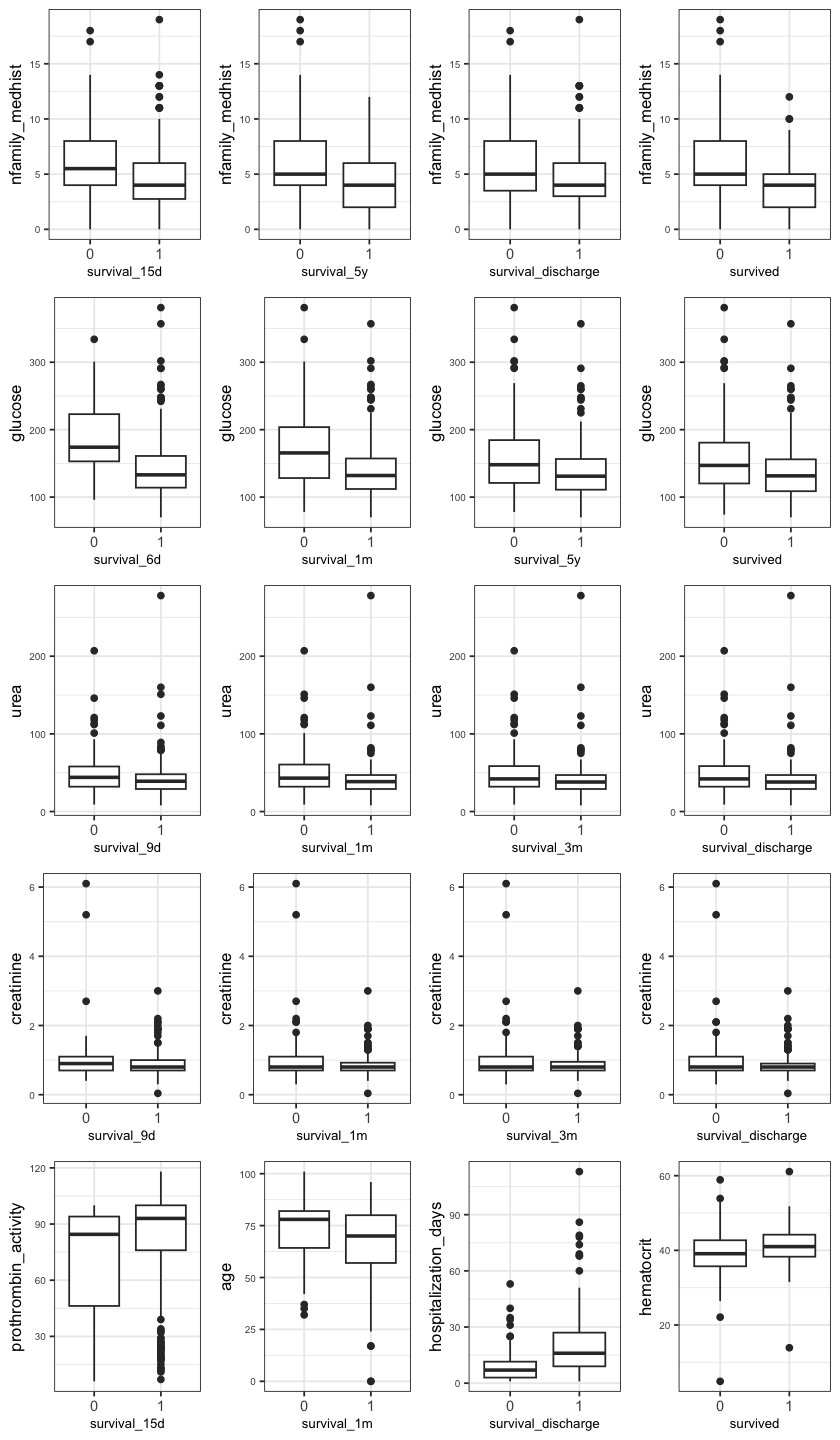

In [40]:
options(repr.plot.width=7, repr.plot.height=12)

cowplot::plot_grid(ggplot(df, aes(x=survival_15d,        y=nfamily_medhist))      + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_5y,         y=nfamily_medhist))      + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_discharge,  y=nfamily_medhist))      + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survived,            y=nfamily_medhist))      + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_6d,         y=glucose))              + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_1m,         y=glucose))              + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_5y,         y=glucose))              + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survived,            y=glucose))              + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_9d,         y=urea))                 + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_1m,         y=urea))                 + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_3m,         y=urea))                 + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_discharge,  y=urea))                 + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_9d,         y=creatinine))           + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_1m,         y=creatinine))           + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_3m,         y=creatinine))           + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_discharge,  y=creatinine))           + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_15d,        y=prothrombin_activity)) + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_1m,         y=age))                  + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survival_discharge,  y=hospitalization_days)) + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=survived,            y=hematocrit))           + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                ncol=4)

###### 4.2.1.3.2. Three or more samples

###### 4.2.1.3.2.1. Hypothesis contrasts

In [41]:
# Three or more samples tests
nrow(not.bin_non.normal_diff.shaped.spread_comp)
head(not.bin_non.normal_diff.shaped.spread_comp)

[1] 129

X1,X2
final_outcome,nfamily_medhist
final_outcome,n_tobacco
final_outcome,g_alcohol
final_outcome,antihypertensives
final_outcome,antidiabetics
final_outcome,hypolipidemics


In [42]:
# Do the Mood's median tests for more than two samples
p.values_med.test3= matrix(unlist(map2(.x= as.character(not.bin_non.normal_diff.shaped.spread_comp[[2]]),
                                       .y= as.character(not.bin_non.normal_diff.shaped.spread_comp[[1]]),
                                       .f= function(x,y) Median_test(df=df,x,y))),
                                       ncol=3,
                                       byrow=TRUE)

# Adjust p values with False Discovery Rate (FDR) method
p.values_med.test3= cbind(p.values_med.test3, p.adjust(p.values_med.test3[,3], method='fdr', n=nrow(p.values_med.test3)))

                               
# Rename and round columns
p.values_med.test3= p.values_med.test3[,c(2,1,3,4)]                   
colnames(p.values_med.test3)= c('var1', 'var2', 'p._med.test', 'p.adj_fdr')
p.values_med.test3[,3:4]= round(as.numeric(p.values_med.test3[,3:4]),4)
p.values_med.test3[,3:4]= ifelse(p.values_med.test3[,3:4] == '0', '<0.0001', p.values_med.test3[,3:4])

# Select significant Mood's median tests
alpha_med.test3= 0.05
sig_med.tests3= p.values_med.test3[which(p.values_med.test3[,4] < alpha_med.test3),]
sig_med.tests3

var1,var2,p._med.test,p.adj_fdr
final_outcome,onset_h,0.0014,0.0096
final_outcome,hospitalizations_1y,<0.0001,<0.0001
final_outcome,hospitalizations_3y,<0.0001,<0.0001
final_outcome,hospitalizations_5y,<0.0001,<0.0001
final_outcome,hospitalization_days,<0.0001,<0.0001
final_outcome,hospitalization_icu_days,0.001,0.0077
final_outcome,glucose,7e-04,0.0063
final_outcome,prothrombin_activity,0.0013,0.0094
final_outcome,inr,0.001,0.0077
follow_up,anticoagulants,0.0024,0.0146


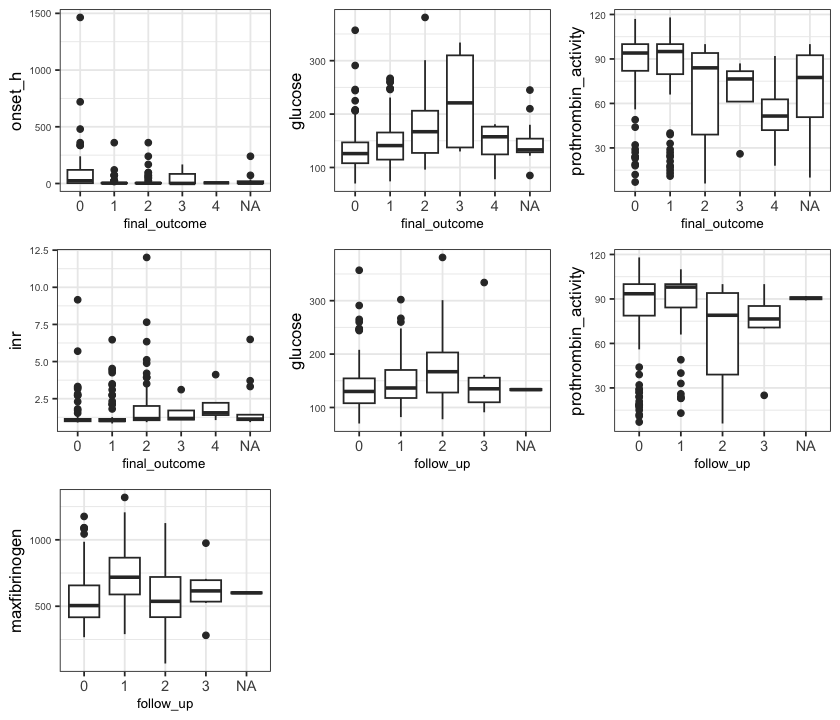

In [43]:
options(repr.plot.width=7, repr.plot.height=6)

cowplot::plot_grid(ggplot(df, aes(x=final_outcome, y=onset_h))              + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=final_outcome, y=glucose))              + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=final_outcome, y=prothrombin_activity)) + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=final_outcome, y=inr))                  + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=follow_up,     y=glucose))              + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=follow_up,     y=prothrombin_activity)) + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=follow_up,     y=maxfibrinogen))        + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                  ncol=3)

###### 4.2.1.3.2.2. Post-hoc analysis

In biostatistics, a ***post-hoc analysis*** consists of hypothesis contrasts done after the data were seen and analyzed. This technique is frequently used after doing hypothesis tests which compared three or more groups, when the tests results are statistically significant. In these cases, it is interesting to do later pairwise comparisons of each group to discover which group or groups are turning the multiple test result significant.

In this project, some post-hoc analysis are done. However, despite all possible pairwise comparisons are usually tested, only a few of them which were considered of clinical and medical interest, were tested.

In [44]:
c('final_outcome:', as.vector(df_metadata[df_metadata['Variable_Label'] == 'final_outcome', 'Values']))
c('follow_up:',     as.vector(df_metadata[df_metadata['Variable_Label'] == 'follow_up',     'Values']))
c('neurosurg:',     as.vector(df_metadata[df_metadata['Variable_Label'] == 'neurosurg',     'Values']))

[1] "final_outcome:"                                                                                                                                                                                                                   
[2] "0 (Complete curation); 1 (Curation with sequelae); 2 (Hospitalization death due to ICH); 3 (Hospitalization death but not due to ICH); 4 (Death in the next three months after hospital discharge due to ICH); NA (Missing value)"

[1] "follow_up:"                                                                                                                                                                                                 
[2] "0 (No deterioration after admission); 1 (Patient deterioration due to the hemorrhage); 2 (Patient death due to the hemorrhage); 3 (Patient deterioration but not due to the hemorrhage); NA (Missing value)"

[1] "neurosurg:"                    "0 (No); 1 (Yes); 2 (VP shunt)"

In [45]:
# Define post-hoc tests
                # Outcome         # Predictor             # idx_values_group2  # values_group1   # values_group2
post_hoc= list(c('final_outcome',  'onset_h',               5,                   0,                1      ),
               c('final_outcome',  'onset_h',               5,                   0,                1, 2, 4),
               c('final_outcome',  'onset_h',               6,                   0,1,                 2, 4),
               c('final_outcome',  'glucose',               5,                   0,                1      ),
               c('final_outcome',  'glucose',               5,                   0,                1, 2, 4),
               c('final_outcome',  'glucose',               6,                   0,1,                 2, 4),
               c('final_outcome',  'prothrombin_activity',  5,                   0,                1      ),
               c('final_outcome',  'prothrombin_activity',  5,                   0,                1, 2, 4),
               c('final_outcome',  'prothrombin_activity',  6,                   0,1,                 2, 4),
               c('final_outcome',  'inr',                   5,                   0,                1      ),
               c('final_outcome',  'inr',                   5,                   0,                1, 2, 4),
               c('final_outcome',  'inr',                   6,                   0,1,                 2, 4),
               
               c('follow_up',  'anticoagulants',            5,                   0,                1, 2   ),
               c('follow_up',  'anticoagulants',            6,                   0,1,                 2   ),
               c('follow_up',  'onset_h',                   5,                   0,                1, 2   ),
               c('follow_up',  'onset_h',                   6,                   0,1,                 2   ),
               c('follow_up',  'glucose',                   5,                   0,                1, 2   ),
               c('follow_up',  'glucose',                   6,                   0,1,                 2   ),
               c('follow_up',  'prothrombin_activity',      5,                   0,                1, 2   ),
               c('follow_up',  'prothrombin_activity',      6,                   0,1,                 2   ),
               c('follow_up',  'maxfibrinogen',             5,                   0,                1, 2   ),
               c('follow_up',  'maxfibrinogen',             6,                   0,1,                 2   ),
               
               c('neurosurg',  'maxfibrinogen',             5,                   0,                1      ))

In [46]:
# Post-hoc pairwise Mood's median test function
post.hoc_median_test= function (x.test, df) {
    
    # Define the groups and the test
    
    x= x.test[2] # predictor
    y= x.test[1] # outcome
    idx2= as.numeric(x.test[3])
    
    group1_values= as.numeric(x.test[4:(idx2-1)])
    group2_values= as.numeric(x.test[idx2:length(x.test)])
        
    testg1= paste(c(x.test[1], '=', group1_values), collapse=' ')
    testg2= paste(c(x.test[1], '=', group2_values), collapse=' ')
    test=   paste('(group1)', testg1, 'vs', '(group2)', testg2, '---> ', '(predictor)', x.test[2])
    
    
    df_= df[which(df[[y]] %in% c(group1_values,group2_values)),] # Filter only groups 1 and 2 cells
    df_['y2']= ifelse(as.numeric(df_[[y]]) %in% (group1_values+1), 'group1', 'group2') # convert outcomes to binary: careful, conversion to numeric adds +1
    df_['y2']= as.factor(df_[['y2']])
    
    # Do the pairwise Mood's median test
    
    Median.test_result= coin::pvalue(
                        coin::median_test(df_[[x]]~df_[['y2']],
                                          alternative='two.sided', paired=FALSE, conf.level=0.95))
    
    return (c(testg1,testg2,x.test[2], Median.test_result))}




# Do post-hoc pairwise Mood's median test
p.values_post.hoc_med.test= matrix(unlist(map(.x=post_hoc,
                                              .f= function(x.test) post.hoc_median_test(x.test, df=df))),
                                              ncol=4, byrow=TRUE)

                                          
# Adjust p values with False Discovery Rate (FDR) method
p.values_post.hoc_med.test= cbind(p.values_post.hoc_med.test, p.adjust(p.values_post.hoc_med.test[,4], method='fdr', n=nrow(p.values_post.hoc_med.test)))

                               
# Rename and round columns
colnames(p.values_post.hoc_med.test)= c('group1', 'group1', 'predictor', 'p._med.test', 'p.adj_fdr')
p.values_post.hoc_med.test[,4:5]= round(as.numeric(p.values_post.hoc_med.test[,4:5]),4)
p.values_post.hoc_med.test[,4:5]= ifelse(p.values_post.hoc_med.test[,4:5] == '0', '<0.0001', p.values_post.hoc_med.test[,4:5])

# Select significant Mood's median tests
alpha_post.hoc_med.test= 0.05
sig_post.hoc_med.test= p.values_post.hoc_med.test[which(p.values_post.hoc_med.test[,5] < alpha_post.hoc_med.test),]
sig_post.hoc_med.test

group1,group1,predictor,p._med.test,p.adj_fdr
final_outcome = 0,final_outcome = 1,onset_h,<0.0001,<0.0001
final_outcome = 0,final_outcome = 1 2 4,onset_h,<0.0001,<0.0001
final_outcome = 0 1,final_outcome = 2 4,onset_h,0.0175,0.0269
follow_up = 0,follow_up = 1 2,onset_h,7e-04,0.0013
follow_up = 0 1,follow_up = 2,onset_h,0.0085,0.014
follow_up = 0,follow_up = 1 2,glucose,0.0021,0.0037
neurosurg = 0,neurosurg = 1,maxfibrinogen,<0.0001,<0.0001


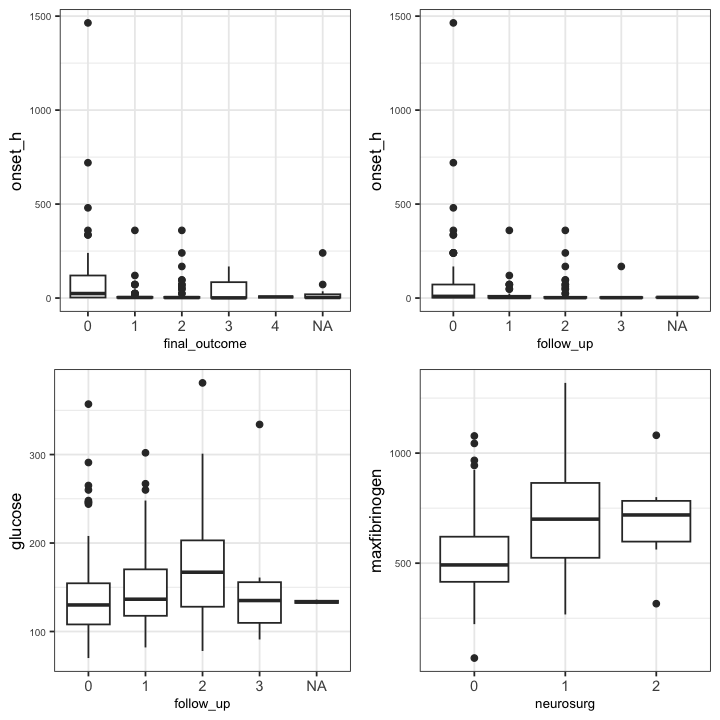

In [47]:
options(repr.plot.width=6, repr.plot.height=6)

cowplot::plot_grid(ggplot(df, aes(x=final_outcome, y=onset_h))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=follow_up,     y=onset_h))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=follow_up,     y=glucose))       + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                   ggplot(df, aes(x=neurosurg,     y=maxfibrinogen)) + geom_boxplot() + theme_bw() + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6)),
                  ncol=2)

#### 4.2.2 Qualitative outcomes vs qualitative predictors

   - Contingency tables $RxC$ when at least the 80% of the expected frequencies (($row$ $total$ $*$ $column$ $total)/N$) are equal to or greater than 5:
       - **Chi-square test**: contingency tables with > 80% expected frequencies n ≥ 5, regardless of row and column sizes.
       - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.


   - Contingency tables $RxC$ when at least the 20% of the expected frequencies are lesser than 5:
      - **Chi-square test with Monte Carlo simulated p.values**: contingency tables regardless of frequencies and sizes.
      - **Fisher's exact test**: contingency tables 2x2 with > 20% expected frequencies n < 5.
      - **Fisher-Freeman-Halton**: Contingency tables > 2x2 with > 20% expected frequencies n < 5.
      
*Note: For Monte Carlo simulation, 1.000.000 replicates was used.*

In [48]:
qual_outcomes

[1] "follow_up"          "final_outcome"      "survival_discharge"
 [4] "survival_3d"        "survival_6d"        "survival_9d"       
 [7] "survival_12d"       "survival_15d"       "survival_1m"       
[10] "survival_3m"        "survival_1y"        "survival_5y"       
[13] "survived"           "neurosurg"          "interprocedures"

In [49]:
qual_predictors

[1] "sex"                           "tobacco"                      
 [3] "drugs"                         "alcohol"                      
 [5] "ht"                            "dmellitus"                    
 [7] "dyslipidemia"                  "previous_ich"                 
 [9] "cv_diseases"                   "carrhythmias"                 
[11] "structural_heart_disease"      "vascular_diseases"            
[13] "neurological_diseases"         "dementia"                     
[15] "depression"                    "psychiatric_diseases"         
[17] "cancerous_autoimmune_diseases" "cancerous_diseases"           
[19] "autoimmune_diseases"           "hyper_hypo_thyroidism"        
[21] "haematological_disorders"      "other_diseases"               
[23] "digoxin"                       "aceis"                        
[25] "arbs"                          "ccbs"                         
[27] "bblockers"                     "ablockers"                    
[29] "ablockers1"                    "ablockers2"                   
[31] "diuretics"                     "other_antihypertensives"      
[33] "biguanides"                    "sulfonylureas"                
[35] "glinides"                      "glp1a"                        
[37] "dpp4i"                         "agi"                          
[39] "insulin"                       "statins"                      
[41] "aspirin"                       "p2y12b"                       
[43] "gIIbIIIai"                     "cumarinics"                   
[45] "noac"                          "dabigatran"                   
[47] "rivaroxaban"                   "other_medications"            
[49] "headache"                      "emesis"                       
[51] "visual_disturbances"           "seizures"                     
[53] "mh_trauma"                     "mh_le_trauma"                 
[55] "mh_he_trauma"                  "other_symptoms"               
[57] "neurol_signs"                  "diplopia"                     
[59] "anisocoria"                    "aphasia"                      
[61] "dysarthria"                    "altered_consciousness"        
[63] "nuchal_rigidity"               "rfacial_palsy"                
[65] "lfacial_palsy"                 "ruplimb_mimpairment"          
[67] "luplimb_mimpairment"           "rlwlimb_mimpairment"          
[69] "llwlimb_mimpairment"           "balance_impairment"           
[71] "tgcs"                          "primary_ich"                  
[73] "vascular_ich"                  "traumatic_ich"                
[75] "ht_ich"                        "amyloidangiopathy_ich"        
[77] "aneurysmal_ich"                "avm_ich"                      
[79] "hti_ich"                       "other_ich"

###### NOTE

Associations and relationships between independent **qualitative/categorical variables** (*proportions*) can be explore by doing ***Chi-square tests*** and their variants (***Fisher exact test***, ***Yates correction***, etc.). One easy approach to just compute one kind of test for all the scenarios, is to do a *Chi-square test* by calculating the *p-value* doing *Monte Carlo simulations*.

Although the ***Chi-square test with Monte Carlo simulated p-values*** is not computationally efficient, in this project it was chosen as the statistical test to compare qualitative outcomes and qualitative predictors in order to simplify the analysis. Otherwise, the expected frequencies of each ***contingency table*** should be checked to subsequently chose the appropriate test based on the size of the table and the expected frequencies calculated. *Chi-square test with Monte Carlo simulated p-values* allows to compare all kind of contingency tables.

In [50]:
# Chi-square tests with Monte Carlo simulated p-values function
chi.square_MonteCarlo= function (df,x,y){
    
    freqs= table(df[[x]],df[[y]])
    chi.square_MonteCarlo_results= stats::chisq.test(x=freqs,
                                                     correct=FALSE, rescale.p=FALSE,
                                                     simulate.p.value=TRUE, B=1000000)
    
    return (c(x,y,chi.square_MonteCarlo_results$p.value))}


# Do the Chi-square tests with Monte Carlo simulated p-values
p.values_chi.square_MonteCarlo_test= matrix(unlist(map2(.x=sort(rep(qual_outcomes, length(qual_predictors))),
                                                        .y=rep(qual_predictors, length(qual_outcomes)),
                                                        .f=function(x,y) chi.square_MonteCarlo(df=df,x,y))),
                                                        ncol=3, byrow=TRUE)
                                              

# Adjust p values with False Discovery Rate (FDR) method         
p.values_chi.square_MonteCarlo_test= cbind(p.values_chi.square_MonteCarlo_test,
        p.adjust(p.values_chi.square_MonteCarlo_test[,3], method='fdr', n=nrow(p.values_chi.square_MonteCarlo_test)))

                               
# Rename and round columns
colnames(p.values_chi.square_MonteCarlo_test)= c('var1', 'var2', 'p._chi.square_MC.test', 'p.adj_fdr')
p.values_chi.square_MonteCarlo_test[,3:4]= round(as.numeric(p.values_chi.square_MonteCarlo_test[,3:4]),4)
p.values_chi.square_MonteCarlo_test[,3:4]= ifelse(p.values_chi.square_MonteCarlo_test[,3:4] == '0', '<0.0001', p.values_chi.square_MonteCarlo_test[,3:4])
                               

# Select significant Chi-square tests with Monte Carlo simulated p-values
alpha_chi.square_MC_test= 0.05
sig_chi.square_MC.tests= p.values_chi.square_MonteCarlo_test[which(p.values_chi.square_MonteCarlo_test[,4] < alpha_chi.square_MC_test),]
sig_chi.square_MC.tests

var1,var2,p._chi.square_MC.test,p.adj_fdr
final_outcome,arbs,0.0047,0.0357
final_outcome,dysarthria,0.0051,0.0379
final_outcome,ruplimb_mimpairment,0.0037,0.0296
final_outcome,luplimb_mimpairment,8e-04,0.0093
final_outcome,rlwlimb_mimpairment,0.0022,0.0197
final_outcome,llwlimb_mimpairment,0.0014,0.0139
final_outcome,tgcs,2e-04,0.0025
final_outcome,primary_ich,1e-04,0.0017
final_outcome,ht_ich,9e-04,0.0098
follow_up,carrhythmias,0.0026,0.0217


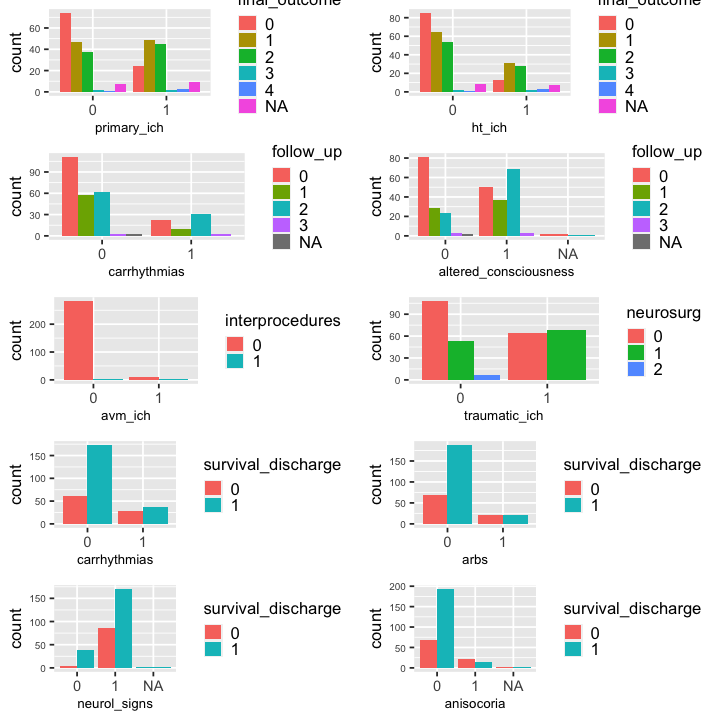

In [51]:
cowplot::plot_grid(ggplot(df, aes(x=primary_ich,           y=after_stat(count))) + geom_bar(aes(fill=final_outcome),      position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=ht_ich,                y=after_stat(count))) + geom_bar(aes(fill=final_outcome),      position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=carrhythmias,          y=after_stat(count))) + geom_bar(aes(fill=follow_up),          position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)), 
                   ggplot(df, aes(x=altered_consciousness, y=after_stat(count))) + geom_bar(aes(fill=follow_up),          position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=avm_ich,               y=after_stat(count))) + geom_bar(aes(fill=interprocedures),    position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=traumatic_ich,         y=after_stat(count))) + geom_bar(aes(fill=neurosurg),          position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=carrhythmias,          y=after_stat(count))) + geom_bar(aes(fill=survival_discharge), position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=arbs,                  y=after_stat(count))) + geom_bar(aes(fill=survival_discharge), position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=neurol_signs,          y=after_stat(count))) + geom_bar(aes(fill=survival_discharge), position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                   ggplot(df, aes(x=anisocoria,            y=after_stat(count))) + geom_bar(aes(fill=survival_discharge), position='dodge') + theme(axis.title.y=element_text(size=10), axis.title.x=element_text(size=8), axis.text.y=element_text(size=6), legend.key.size=unit(4,'mm'), legend.key.height=unit(3.5,'mm'), legend.key.width=unit(4,'mm'), legend.title=element_text(size=10), legend.text=element_text(size=10)),
                ncol=2)